# **Deforum Stable Diffusion v0.5**
[Stable Diffusion](https://github.com/CompVis/stable-diffusion) by Robin Rombach, Andreas Blattmann, Dominik Lorenz, Patrick Esser, Björn Ommer and the [Stability.ai](https://stability.ai/) Team. [K Diffusion](https://github.com/crowsonkb/k-diffusion) by [Katherine Crowson](https://twitter.com/RiversHaveWings). You need to get the ckpt file and put it on your Google Drive first to use this. It can be downloaded from [HuggingFace](https://huggingface.co/CompVis/stable-diffusion).

Notebook by [deforum](https://discord.gg/upmXXsrwZc)

By using this Notebook, you agree to the following Terms of Use, and license:

**Stablity.AI Model Terms of Use**

This model is open access and available to all, with a CreativeML OpenRAIL-M license further specifying rights and usage.

The CreativeML OpenRAIL License specifies:

You can't use the model to deliberately produce nor share illegal or harmful outputs or content
CompVis claims no rights on the outputs you generate, you are free to use them and are accountable for their use which must not go against the provisions set in the license
You may re-distribute the weights and use the model commercially and/or as a service. If you do, please be aware you have to include the same use restrictions as the ones in the license and share a copy of the CreativeML OpenRAIL-M to all your users (please read the license entirely and carefully)


Please read the full license here: https://huggingface.co/spaces/CompVis/stable-diffusion-license

# Setup

In [1]:
exit() # Uncomment and run if running out of memory. It kills the notebook and restarts. (Pablx)

In [1]:
#@markdown **NVIDIA GPU**

import subprocess
sub_p_res = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total,memory.free', '--format=csv,noheader'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(f"{sub_p_res[:-1]}")

#IMPORTANT: If having problems with any error that mention "cuda:0" change my_cuda to "cuda" instead of "cuda:0". (Pablx)
my_cuda = "cuda:0" # This could be used to change to cuda:1 if needed, but I haven't tested this.  (Pablx)

# After setting your paths (and turning mount_google_drive to True if using on Google Colab) you can collapse this cell.  (Pablx)
import subprocess, time
very_start_time = time.time()

#@markdown **Model and Output Paths**
# Change this to your own paths (Pablx)
models_path = "modelos" #@param {type:"string"}
output_path = "salida" #@param {type:"string"}

#@markdown **Google Drive Path Variables (Optional)**
# I use the jupyter notebook locally, and have never gotten to work google_drive, but you can turn it on if using it on Colab  (Pablx)
mount_google_drive = False #@param {type:"boolean"}
force_remount = False

try:
   ipy = get_ipython()
except:
   ipy = 'could not get_ipython'

if 'google.colab' in str(ipy):
    if mount_google_drive:
        from google.colab import drive # type: ignore
        try:
            drive_path = "/content/drive"
            drive.mount(drive_path,force_remount=force_remount)
            models_path_gdrive = "/content/drive/MyDrive/AI/models" #@param {type:"string"}
            output_path_gdrive = "/content/drive/MyDrive/AI/StableDiffusion" #@param {type:"string"}
            models_path = models_path_gdrive
            output_path = output_path_gdrive
        except:
            print("..error mounting drive or with drive path variables")
            print("..reverting to default path variables")

import os, sys
models_path = os.path.abspath(models_path)
output_path = os.path.abspath(output_path)
os.makedirs(models_path, exist_ok=True)
os.makedirs(output_path, exist_ok=True)

print(f"models_path: {models_path}")
print(f"output_path: {output_path}")

#@markdown **Setup Environment**
print_subprocess = False

if 'google.colab' in str(ipy):
    import subprocess, time
    print("Setting up environment...")
    start_time = time.time()
    all_process = [
        ['pip', 'install', 'torch==1.12.1+cu113', 'torchvision==0.13.1+cu113', '--extra-index-url', 'https://download.pytorch.org/whl/cu113'],
        ['pip', 'install', 'omegaconf==2.2.3', 'einops==0.4.1', 'pytorch-lightning==1.7.4', 'torchmetrics==0.9.3', 'torchtext==0.13.1', 'transformers==4.21.2', 'kornia==0.6.7'],
        ['git', 'clone',  '-b', 'local', 'https://github.com/deforum/stable-diffusion'],
        ['pip', 'install', 'accelerate', 'ftfy', 'jsonmerge', 'matplotlib', 'resize-right', 'timm', 'torchdiffeq'],
    ]
    for process in all_process:
        running = subprocess.run(process,stdout=subprocess.PIPE).stdout.decode('utf-8')
        if print_subprocess:
            print(running)

    with open('stable-diffusion/src/k_diffusion/__init__.py', 'w') as f:
        f.write('')

    sys.path.extend([
        'stable-diffusion/',
        'stable-diffusion/src',
    ])

    end_time = time.time()
    print(f"Environment set up in {end_time-start_time:.0f} seconds")
    
else:

    sys.path.extend([
        'src'
    ])

#@markdown **Python Definitions**
import json
from IPython import display

import gc, math, os, pathlib, subprocess, sys, time
import cv2
import numpy as np
import pandas as pd
import random
import requests
import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from contextlib import contextmanager, nullcontext
from einops import rearrange, repeat
from omegaconf import OmegaConf
from PIL import Image
from pytorch_lightning import seed_everything
from skimage.exposure import match_histograms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
from types import SimpleNamespace
from torch import autocast
import re
from scipy.ndimage import gaussian_filter

import py3d_tools as p3d

from helpers import DepthModel, sampler_fn
from k_diffusion.external import CompVisDenoiser
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler

from transformers import logging
logging.set_verbosity_error()

def sanitize(prompt):
    whitelist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    tmp = ''.join(filter(whitelist.__contains__, prompt))
    return tmp.replace(' ', '_')

from functools import reduce
def construct_RotationMatrixHomogenous(rotation_angles):
    assert(type(rotation_angles)==list and len(rotation_angles)==3)
    RH = np.eye(4,4)
    cv2.Rodrigues(np.array(rotation_angles), RH[0:3, 0:3])
    return RH

# https://en.wikipedia.org/wiki/Rotation_matrix
def getRotationMatrixManual(rotation_angles):
	
    rotation_angles = [np.deg2rad(x) for x in rotation_angles]
    
    phi         = rotation_angles[0] # around x
    gamma       = rotation_angles[1] # around y
    theta       = rotation_angles[2] # around z
    
    # X rotation
    Rphi        = np.eye(4,4)
    sp          = np.sin(phi)
    cp          = np.cos(phi)
    Rphi[1,1]   = cp
    Rphi[2,2]   = Rphi[1,1]
    Rphi[1,2]   = -sp
    Rphi[2,1]   = sp
    
    # Y rotation
    Rgamma        = np.eye(4,4)
    sg            = np.sin(gamma)
    cg            = np.cos(gamma)
    Rgamma[0,0]   = cg
    Rgamma[2,2]   = Rgamma[0,0]
    Rgamma[0,2]   = sg
    Rgamma[2,0]   = -sg
    
    # Z rotation (in-image-plane)
    Rtheta      = np.eye(4,4)
    st          = np.sin(theta)
    ct          = np.cos(theta)
    Rtheta[0,0] = ct
    Rtheta[1,1] = Rtheta[0,0]
    Rtheta[0,1] = -st
    Rtheta[1,0] = st
    
    R           = reduce(lambda x,y : np.matmul(x,y), [Rphi, Rgamma, Rtheta]) 
    
    return R


def getPoints_for_PerspectiveTranformEstimation(ptsIn, ptsOut, W, H, sidelength):
    
    ptsIn2D      =  ptsIn[0,:]
    ptsOut2D     =  ptsOut[0,:]
    ptsOut2Dlist =  []
    ptsIn2Dlist  =  []
    
    for i in range(0,4):
        ptsOut2Dlist.append([ptsOut2D[i,0], ptsOut2D[i,1]])
        ptsIn2Dlist.append([ptsIn2D[i,0], ptsIn2D[i,1]])
    
    pin  =  np.array(ptsIn2Dlist)   +  [W/2.,H/2.]
    pout = (np.array(ptsOut2Dlist)  +  [1.,1.]) * (0.5*sidelength)
    pin  = pin.astype(np.float32)
    pout = pout.astype(np.float32)
    
    return pin, pout

def warpMatrix(W, H, theta, phi, gamma, scale, fV):
    
    # M is to be estimated
    M          = np.eye(4, 4)
    
    fVhalf     = np.deg2rad(fV/2.)
    d          = np.sqrt(W*W+H*H)
    sideLength = scale*d/np.cos(fVhalf)
    h          = d/(2.0*np.sin(fVhalf))
    n          = h-(d/2.0);
    f          = h+(d/2.0);
    
    # Translation along Z-axis by -h
    T       = np.eye(4,4)
    T[2,3]  = -h
    
    # Rotation matrices around x,y,z
    R = getRotationMatrixManual([phi, gamma, theta])
    
    
    # Projection Matrix 
    P       = np.eye(4,4)
    P[0,0]  = 1.0/np.tan(fVhalf)
    P[1,1]  = P[0,0]
    P[2,2]  = -(f+n)/(f-n)
    P[2,3]  = -(2.0*f*n)/(f-n)
    P[3,2]  = -1.0
    
    # pythonic matrix multiplication
    F       = reduce(lambda x,y : np.matmul(x,y), [P, T, R]) 
    
    # shape should be 1,4,3 for ptsIn and ptsOut since perspectiveTransform() expects data in this way. 
    # In C++, this can be achieved by Mat ptsIn(1,4,CV_64FC3);
    ptsIn = np.array([[
                 [-W/2., H/2., 0.],[ W/2., H/2., 0.],[ W/2.,-H/2., 0.],[-W/2.,-H/2., 0.]
                 ]])
    ptsOut  = np.array(np.zeros((ptsIn.shape), dtype=ptsIn.dtype))
    ptsOut  = cv2.perspectiveTransform(ptsIn, F)
    
    ptsInPt2f, ptsOutPt2f = getPoints_for_PerspectiveTranformEstimation(ptsIn, ptsOut, W, H, sideLength)
    
    # check float32 otherwise OpenCV throws an error
    assert(ptsInPt2f.dtype  == np.float32)
    assert(ptsOutPt2f.dtype == np.float32)
    M33 = cv2.getPerspectiveTransform(ptsInPt2f,ptsOutPt2f)

    return M33, sideLength

def anim_frame_warp_2d(prev_img_cv2, args, anim_args, keys, frame_idx):
    angle = keys.angle_series[frame_idx]
    zoom = keys.zoom_series[frame_idx]
    translation_x = keys.translation_x_series[frame_idx]
    translation_y = keys.translation_y_series[frame_idx]

    center = (args.W // 2, args.H // 2)
    trans_mat = np.float32([[1, 0, translation_x], [0, 1, translation_y]])
    rot_mat = cv2.getRotationMatrix2D(center, angle, zoom)
    trans_mat = np.vstack([trans_mat, [0,0,1]])
    rot_mat = np.vstack([rot_mat, [0,0,1]])
    if anim_args.flip_2d_perspective:
        perspective_flip_theta = keys.perspective_flip_theta_series[frame_idx]
        perspective_flip_phi = keys.perspective_flip_phi_series[frame_idx]
        perspective_flip_gamma = keys.perspective_flip_gamma_series[frame_idx]
        perspective_flip_fv = keys.perspective_flip_fv_series[frame_idx]
        M,sl = warpMatrix(args.W, args.H, perspective_flip_theta, perspective_flip_phi, perspective_flip_gamma, 1., perspective_flip_fv);
        post_trans_mat = np.float32([[1, 0, (args.W-sl)/2], [0, 1, (args.H-sl)/2]])
        post_trans_mat = np.vstack([post_trans_mat, [0,0,1]])
        bM = np.matmul(M, post_trans_mat)
        xform = np.matmul(bM, rot_mat, trans_mat)
    else:
        xform = np.matmul(rot_mat, trans_mat)

    return cv2.warpPerspective(
        prev_img_cv2,
        xform,
        (prev_img_cv2.shape[1], prev_img_cv2.shape[0]),
        borderMode=cv2.BORDER_WRAP if anim_args.border == 'wrap' else cv2.BORDER_REPLICATE
    )

def anim_frame_warp_3d(prev_img_cv2, depth, anim_args, keys, frame_idx):
    TRANSLATION_SCALE = 1.0/200.0 # matches Disco
    translate_xyz = [
        -keys.translation_x_series[frame_idx] * TRANSLATION_SCALE, 
        keys.translation_y_series[frame_idx] * TRANSLATION_SCALE, 
        -keys.translation_z_series[frame_idx] * TRANSLATION_SCALE
    ]
    rotate_xyz = [
        math.radians(keys.rotation_3d_x_series[frame_idx]), 
        math.radians(keys.rotation_3d_y_series[frame_idx]), 
        math.radians(keys.rotation_3d_z_series[frame_idx])
    ]
    rot_mat = p3d.euler_angles_to_matrix(torch.tensor(rotate_xyz, device=device), "XYZ").unsqueeze(0)
    result = transform_image_3d(prev_img_cv2, depth, rot_mat, translate_xyz, anim_args)
    torch.cuda.empty_cache()
    return result

def add_noise(sample: torch.Tensor, noise_amt: float) -> torch.Tensor:
    return sample + torch.randn(sample.shape, device=sample.device) * noise_amt

def get_output_folder(output_path, batch_folder):
    out_path = os.path.join(output_path,time.strftime('%Y-%m'))
    if batch_folder != "":
        out_path = os.path.join(out_path, time.strftime('%d%H%M') + batch_folder)
    os.makedirs(out_path, exist_ok=True)
    return out_path

def load_img(path, shape, use_alpha_as_mask=False):
    # use_alpha_as_mask: Read the alpha channel of the image as the mask image
    if path.startswith('http://') or path.startswith('https://'):
        image = Image.open(requests.get(path, stream=True).raw)
    else:
        image = Image.open(path)

    if use_alpha_as_mask:
        image = image.convert('RGBA')
    else:
        image = image.convert('RGB')

    image = image.resize(shape, resample=Image.LANCZOS)

    mask_image = None
    if use_alpha_as_mask:
      # Split alpha channel into a mask_image
      red, green, blue, alpha = Image.Image.split(image)
      mask_image = alpha.convert('L')
      image = image.convert('RGB')

    image = np.array(image).astype(np.float16) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    image = 2.*image - 1.

    return image, mask_image

def load_mask_latent(mask_input, shape):
    # mask_input (str or PIL Image.Image): Path to the mask image or a PIL Image object
    # shape (list-like len(4)): shape of the image to match, usually latent_image.shape
    
    if isinstance(mask_input, str): # mask input is probably a file name
        if mask_input.startswith('http://') or mask_input.startswith('https://'):
            mask_image = Image.open(requests.get(mask_input, stream=True).raw).convert('RGBA')
        else:
            mask_image = Image.open(mask_input).convert('RGBA')
    elif isinstance(mask_input, Image.Image):
        mask_image = mask_input
    else:
        raise Exception("mask_input must be a PIL image or a file name")

    mask_w_h = (shape[-1], shape[-2])
    mask = mask_image.resize(mask_w_h, resample=Image.LANCZOS)
    mask = mask.convert("L")
    return mask

def prepare_mask(mask_input, mask_shape, mask_brightness_adjust=1.0, mask_contrast_adjust=1.0):
    # mask_input (str or PIL Image.Image): Path to the mask image or a PIL Image object
    # shape (list-like len(4)): shape of the image to match, usually latent_image.shape
    # mask_brightness_adjust (non-negative float): amount to adjust brightness of the iamge, 
    #     0 is black, 1 is no adjustment, >1 is brighter
    # mask_contrast_adjust (non-negative float): amount to adjust contrast of the image, 
    #     0 is a flat grey image, 1 is no adjustment, >1 is more contrast
    
    mask = load_mask_latent(mask_input, mask_shape)

    # Mask brightness/contrast adjustments
    if mask_brightness_adjust != 1:
        mask = TF.adjust_brightness(mask, mask_brightness_adjust)
    if mask_contrast_adjust != 1:
        mask = TF.adjust_contrast(mask, mask_contrast_adjust)

    # Mask image to array
    mask = np.array(mask).astype(np.float32) / 255.0
    mask = np.tile(mask,(4,1,1))
    mask = np.expand_dims(mask,axis=0)
    mask = torch.from_numpy(mask)

    if args.invert_mask:
        mask = ( (mask - 0.5) * -1) + 0.5
    
    mask = np.clip(mask,0,1)
    return mask

def maintain_colors(prev_img, color_match_sample, mode):
    if mode == 'Match Frame 0 RGB':
        return match_histograms(prev_img, color_match_sample, multichannel=True)
    elif mode == 'Match Frame 0 HSV':
        prev_img_hsv = cv2.cvtColor(prev_img, cv2.COLOR_RGB2HSV)
        color_match_hsv = cv2.cvtColor(color_match_sample, cv2.COLOR_RGB2HSV)
        matched_hsv = match_histograms(prev_img_hsv, color_match_hsv, multichannel=True)
        return cv2.cvtColor(matched_hsv, cv2.COLOR_HSV2RGB)
    else: # Match Frame 0 LAB
        prev_img_lab = cv2.cvtColor(prev_img, cv2.COLOR_RGB2LAB)
        color_match_lab = cv2.cvtColor(color_match_sample, cv2.COLOR_RGB2LAB)
        matched_lab = match_histograms(prev_img_lab, color_match_lab, multichannel=True)
        return cv2.cvtColor(matched_lab, cv2.COLOR_LAB2RGB)


#
# Callback functions
#
class SamplerCallback(object):
    # Creates the callback function to be passed into the samplers for each step
    def __init__(self, args, mask=None, init_latent=None, sigmas=None, sampler=None,
                  verbose=False):
        self.sampler_name = args.sampler
        self.dynamic_threshold = args.dynamic_threshold
        self.static_threshold = args.static_threshold
        self.mask = mask
        self.init_latent = init_latent 
        self.sigmas = sigmas
        self.sampler = sampler
        self.verbose = verbose

        self.batch_size = args.n_samples
        self.save_sample_per_step = args.save_sample_per_step
        self.show_sample_per_step = args.show_sample_per_step
        self.paths_to_image_steps = [os.path.join( args.outdir, f"{args.timestring}_{index:02}_{args.seed}") for index in range(args.n_samples) ]

        if self.save_sample_per_step:
            for path in self.paths_to_image_steps:
                os.makedirs(path, exist_ok=True)

        self.step_index = 0

        self.noise = None
        if init_latent is not None:
            self.noise = torch.randn_like(init_latent, device=device)

        self.mask_schedule = None
        if sigmas is not None and len(sigmas) > 0:
            self.mask_schedule, _ = torch.sort(sigmas/torch.max(sigmas))
        elif len(sigmas) == 0:
            self.mask = None # no mask needed if no steps (usually happens because strength==1.0)

        if self.sampler_name in ["plms","ddim"]: 
            if mask is not None:
                assert sampler is not None, "Callback function for stable-diffusion samplers requires sampler variable"

        if self.sampler_name in ["plms","ddim"]: 
            # Callback function formated for compvis latent diffusion samplers
            self.callback = self.img_callback_
        else: 
            # Default callback function uses k-diffusion sampler variables
            self.callback = self.k_callback_

        self.verbose_print = print if verbose else lambda *args, **kwargs: None

    def view_sample_step(self, latents, path_name_modifier=''):
        if self.save_sample_per_step or self.show_sample_per_step:
            samples = model.decode_first_stage(latents)
            if self.save_sample_per_step:
                fname = f'{path_name_modifier}_{self.step_index:05}.png'
                for i, sample in enumerate(samples):
                    sample = sample.double().cpu().add(1).div(2).clamp(0, 1)
                    sample = torch.tensor(np.array(sample))
                    grid = make_grid(sample, 4).cpu()
                    TF.to_pil_image(grid).save(os.path.join(self.paths_to_image_steps[i], fname))
            if self.show_sample_per_step:
                print(path_name_modifier)
                self.display_images(samples)
        return

    def display_images(self, images):
        images = images.double().cpu().add(1).div(2).clamp(0, 1)
        images = torch.tensor(np.array(images))
        grid = make_grid(images, 4).cpu()
        display.display(TF.to_pil_image(grid))
        return

    # The callback function is applied to the image at each step
    def dynamic_thresholding_(self, img, threshold):
        # Dynamic thresholding from Imagen paper (May 2022)
        s = np.percentile(np.abs(img.cpu()), threshold, axis=tuple(range(1,img.ndim)))
        s = np.max(np.append(s,1.0))
        torch.clamp_(img, -1*s, s)
        torch.FloatTensor.div_(img, s)

    # Callback for samplers in the k-diffusion repo, called thus:
    #   callback({'x': x, 'i': i, 'sigma': sigmas[i], 'sigma_hat': sigmas[i], 'denoised': denoised})
    def k_callback_(self, args_dict):
        self.step_index = args_dict['i']
        if self.dynamic_threshold is not None:
            self.dynamic_thresholding_(args_dict['x'], self.dynamic_threshold)
        if self.static_threshold is not None:
            torch.clamp_(args_dict['x'], -1*self.static_threshold, self.static_threshold)
        if self.mask is not None:
            init_noise = self.init_latent + self.noise * args_dict['sigma']
            is_masked = torch.logical_and(self.mask >= self.mask_schedule[args_dict['i']], self.mask != 0 )
            new_img = init_noise * torch.where(is_masked,1,0) + args_dict['x'] * torch.where(is_masked,0,1)
            args_dict['x'].copy_(new_img)

        self.view_sample_step(args_dict['denoised'], "x0_pred")

    # Callback for Compvis samplers
    # Function that is called on the image (img) and step (i) at each step
    def img_callback_(self, img, i):
        self.step_index = i
        # Thresholding functions
        if self.dynamic_threshold is not None:
            self.dynamic_thresholding_(img, self.dynamic_threshold)
        if self.static_threshold is not None:
            torch.clamp_(img, -1*self.static_threshold, self.static_threshold)
        if self.mask is not None:
            i_inv = len(self.sigmas) - i - 1
            init_noise = self.sampler.stochastic_encode(self.init_latent, torch.tensor([i_inv]*self.batch_size).to(device), noise=self.noise)
            is_masked = torch.logical_and(self.mask >= self.mask_schedule[i], self.mask != 0 )
            new_img = init_noise * torch.where(is_masked,1,0) + img * torch.where(is_masked,0,1)
            img.copy_(new_img)

        self.view_sample_step(img, "x")

def sample_from_cv2(sample: np.ndarray) -> torch.Tensor:
    sample = ((sample.astype(float) / 255.0) * 2) - 1
    sample = sample[None].transpose(0, 3, 1, 2).astype(np.float16)
    sample = torch.from_numpy(sample)
    return sample

def sample_to_cv2(sample: torch.Tensor, type=np.uint8) -> np.ndarray:
    sample_f32 = rearrange(sample.squeeze().cpu().numpy(), "c h w -> h w c").astype(np.float32)
    sample_f32 = ((sample_f32 * 0.5) + 0.5).clip(0, 1)
    sample_int8 = (sample_f32 * 255)
    return sample_int8.astype(type)

def transform_image_3d(prev_img_cv2, depth_tensor, rot_mat, translate, anim_args):
    # adapted and optimized version of transform_image_3d from Disco Diffusion https://github.com/alembics/disco-diffusion 
    w, h = prev_img_cv2.shape[1], prev_img_cv2.shape[0]

    aspect_ratio = float(w)/float(h)
    near, far, fov_deg = anim_args.near_plane, anim_args.far_plane, anim_args.fov
    persp_cam_old = p3d.FoVPerspectiveCameras(near, far, aspect_ratio, fov=fov_deg, degrees=True, device=device)
    persp_cam_new = p3d.FoVPerspectiveCameras(near, far, aspect_ratio, fov=fov_deg, degrees=True, R=rot_mat, T=torch.tensor([translate]), device=device)

    # range of [-1,1] is important to torch grid_sample's padding handling
    y,x = torch.meshgrid(torch.linspace(-1.,1.,h,dtype=torch.float32,device=device),torch.linspace(-1.,1.,w,dtype=torch.float32,device=device))
    z = torch.as_tensor(depth_tensor, dtype=torch.float32, device=device)
    xyz_old_world = torch.stack((x.flatten(), y.flatten(), z.flatten()), dim=1)

    xyz_old_cam_xy = persp_cam_old.get_full_projection_transform().transform_points(xyz_old_world)[:,0:2]
    xyz_new_cam_xy = persp_cam_new.get_full_projection_transform().transform_points(xyz_old_world)[:,0:2]

    offset_xy = xyz_new_cam_xy - xyz_old_cam_xy
    # affine_grid theta param expects a batch of 2D mats. Each is 2x3 to do rotation+translation.
    identity_2d_batch = torch.tensor([[1.,0.,0.],[0.,1.,0.]], device=device).unsqueeze(0)
    # coords_2d will have shape (N,H,W,2).. which is also what grid_sample needs.
    coords_2d = torch.nn.functional.affine_grid(identity_2d_batch, [1,1,h,w], align_corners=False)
    offset_coords_2d = coords_2d - torch.reshape(offset_xy, (h,w,2)).unsqueeze(0)

    image_tensor = rearrange(torch.from_numpy(prev_img_cv2.astype(np.float32)), 'h w c -> c h w').to(device)
    new_image = torch.nn.functional.grid_sample(
        image_tensor.add(1/512 - 0.0001).unsqueeze(0), 
        offset_coords_2d, 
        mode=anim_args.sampling_mode, 
        padding_mode=anim_args.padding_mode, 
        align_corners=False
    )

    # convert back to cv2 style numpy array
    result = rearrange(
        new_image.squeeze().clamp(0,255), 
        'c h w -> h w c'
    ).cpu().numpy().astype(prev_img_cv2.dtype)
    return result

def check_is_number(value):
    float_pattern = r'^(?=.)([+-]?([0-9]*)(\.([0-9]+))?)$'
    return re.match(float_pattern, value)

# prompt weighting with colons and number coefficients (like 'bacon:0.75 eggs:0.25')
# borrowed from https://github.com/kylewlacy/stable-diffusion/blob/0a4397094eb6e875f98f9d71193e350d859c4220/ldm/dream/conditioning.py
# and https://github.com/raefu/stable-diffusion-automatic/blob/unstablediffusion/modules/processing.py
def get_uc_and_c(prompts, model, args, frame = 0):
    prompt = prompts[0] # they are the same in a batch anyway

    # get weighted sub-prompts
    negative_subprompts, positive_subprompts = split_weighted_subprompts(
        prompt, frame, not args.normalize_prompt_weights
    )

    uc = get_learned_conditioning(model, negative_subprompts, "", args, -1)
    c = get_learned_conditioning(model, positive_subprompts, prompt, args, 1)

    return (uc, c)

def get_learned_conditioning(model, weighted_subprompts, text, args, sign = 1):
    if len(weighted_subprompts) < 1:
        log_tokenization(text, model, args.log_weighted_subprompts, sign)
        c = model.get_learned_conditioning(args.n_samples * [text])
    else:
        c = None
        for subtext, subweight in weighted_subprompts:
            log_tokenization(subtext, model, args.log_weighted_subprompts, sign * subweight)
            if c is None:
                c = model.get_learned_conditioning(args.n_samples * [subtext])
                c *= subweight
            else:
                c.add_(model.get_learned_conditioning(args.n_samples * [subtext]), alpha=subweight)
        
    return c

def parse_weight(match, frame = 0)->float:
    import numexpr
    w_raw = match.group("weight")
    if w_raw == None:
        return 1
    if check_is_number(w_raw):
        return float(w_raw)
    else:
        t = frame
        if len(w_raw) < 3:
            print('the value inside `-characters cannot represent a math function')
            return 1
        return float(numexpr.evaluate(w_raw[1:-1]))

def normalize_prompt_weights(parsed_prompts):
    if len(parsed_prompts) == 0:
        return parsed_prompts
    weight_sum = sum(map(lambda x: x[1], parsed_prompts))
    if weight_sum == 0:
        print(
            "Warning: Subprompt weights add up to zero. Discarding and using even weights instead.")
        equal_weight = 1 / max(len(parsed_prompts), 1)
        return [(x[0], equal_weight) for x in parsed_prompts]
    return [(x[0], x[1] / weight_sum) for x in parsed_prompts]

def split_weighted_subprompts(text, frame = 0, skip_normalize=False):
    """
    grabs all text up to the first occurrence of ':'
    uses the grabbed text as a sub-prompt, and takes the value following ':' as weight
    if ':' has no value defined, defaults to 1.0
    repeats until no text remaining
    """
    prompt_parser = re.compile("""
            (?P<prompt>         # capture group for 'prompt'
            (?:\\\:|[^:])+      # match one or more non ':' characters or escaped colons '\:'
            )                   # end 'prompt'
            (?:                 # non-capture group
            :+                  # match one or more ':' characters
            (?P<weight>((        # capture group for 'weight'
            -?\d+(?:\.\d+)?     # match positive or negative integer or decimal number
            )|(                 # or
            `[\S\s]*?`# a math function
            )))?                 # end weight capture group, make optional
            \s*                 # strip spaces after weight
            |                   # OR
            $                   # else, if no ':' then match end of line
            )                   # end non-capture group
            """, re.VERBOSE)
    negative_prompts = []
    positive_prompts = []
    for match in re.finditer(prompt_parser, text):
        w = parse_weight(match, frame)
        if w < 0:
            # negating the sign as we'll feed this to uc
            negative_prompts.append((match.group("prompt").replace("\\:", ":"), -w))
        elif w > 0:
            positive_prompts.append((match.group("prompt").replace("\\:", ":"), w))

    if skip_normalize:
        return (negative_prompts, positive_prompts)
    return (normalize_prompt_weights(negative_prompts), normalize_prompt_weights(positive_prompts))

# shows how the prompt is tokenized
# usually tokens have '</w>' to indicate end-of-word,
# but for readability it has been replaced with ' '
def log_tokenization(text, model, log=False, weight=1):
    if not log:
        return
    tokens    = model.cond_stage_model.tokenizer._tokenize(text)
    tokenized = ""
    discarded = ""
    usedTokens = 0
    totalTokens = len(tokens)
    for i in range(0, totalTokens):
        token = tokens[i].replace('</w>', ' ')
        # alternate color
        s = (usedTokens % 6) + 1
        if i < model.cond_stage_model.max_length:
            tokenized = tokenized + f"\x1b[0;3{s};40m{token}"
            usedTokens += 1
        else:  # over max token length
            discarded = discarded + f"\x1b[0;3{s};40m{token}"
    print(f"\n>> Tokens ({usedTokens}), Weight ({weight:.2f}):\n{tokenized}\x1b[0m")
    if discarded != "":
        print(
            f">> Tokens Discarded ({totalTokens-usedTokens}):\n{discarded}\x1b[0m"
        )

def generate(args, frame = 0, return_latent=False, return_sample=False, return_c=False):
    seed_everything(args.seed)
    os.makedirs(args.outdir, exist_ok=True)

    sampler = PLMSSampler(model) if args.sampler == 'plms' else DDIMSampler(model)
    model_wrap = CompVisDenoiser(model)
    batch_size = args.n_samples
    prompt = args.prompt
    assert prompt is not None
    data = [batch_size * [prompt]]
    precision_scope = autocast if args.precision == "autocast" else nullcontext

    init_latent = None
    mask_image = None
    init_image = None
    if args.init_latent is not None:
        init_latent = args.init_latent
    elif args.init_sample is not None:
        with precision_scope("cuda"):
            init_latent = model.get_first_stage_encoding(model.encode_first_stage(args.init_sample))
    elif args.use_init and args.init_image != None and args.init_image != '':
        init_image, mask_image = load_img(args.init_image, 
                                          shape=(args.W, args.H),  
                                          use_alpha_as_mask=args.use_alpha_as_mask)
        init_image = init_image.to(device)
        init_image = repeat(init_image, '1 ... -> b ...', b=batch_size)
        with precision_scope("cuda"):
            init_latent = model.get_first_stage_encoding(model.encode_first_stage(init_image))  # move to latent space        

    if not args.use_init and args.strength > 0 and args.strength_0_no_init:
        print("\nNo init image, but strength > 0. Strength has been auto set to 0, since use_init is False.")
        print("If you want to force strength > 0 with no init, please set strength_0_no_init to False.\n")
        args.strength = 0

    # Mask functions
    if args.use_mask:
        assert args.mask_file is not None or mask_image is not None, "use_mask==True: An mask image is required for a mask. Please enter a mask_file or use an init image with an alpha channel"
        assert args.use_init, "use_mask==True: use_init is required for a mask"
        assert init_latent is not None, "use_mask==True: An latent init image is required for a mask"


        mask = prepare_mask(args.mask_file if mask_image is None else mask_image, 
                            init_latent.shape, 
                            args.mask_contrast_adjust, 
                            args.mask_brightness_adjust)
        
        if (torch.all(mask == 0) or torch.all(mask == 1)) and args.use_alpha_as_mask:
            raise Warning("use_alpha_as_mask==True: Using the alpha channel from the init image as a mask, but the alpha channel is blank.")
        
        mask = mask.to(device)
        mask = repeat(mask, '1 ... -> b ...', b=batch_size)
    else:
        mask = None

    assert not ( (args.use_mask and args.overlay_mask) and (args.init_sample is None and init_image is None)), "Need an init image when use_mask == True and overlay_mask == True"
        
    t_enc = int((1.0-args.strength) * args.steps)

    # Noise schedule for the k-diffusion samplers (used for masking)
    k_sigmas = model_wrap.get_sigmas(args.steps)
    k_sigmas = k_sigmas[len(k_sigmas)-t_enc-1:]

    if args.sampler in ['plms','ddim']:
        sampler.make_schedule(ddim_num_steps=args.steps, ddim_eta=args.ddim_eta, ddim_discretize='fill', verbose=False)

    callback = SamplerCallback(args=args,
                            mask=mask, 
                            init_latent=init_latent,
                            sigmas=k_sigmas,
                            sampler=sampler,
                            verbose=False).callback  

    results = []
    with torch.no_grad():
        with precision_scope("cuda"):
            with model.ema_scope():
                for prompts in data:
                    if isinstance(prompts, tuple):
                        prompts = list(prompts)
                    if args.prompt_weighting:
                        uc, c = get_uc_and_c(prompts, model, args, frame)
                    else:
                        uc = model.get_learned_conditioning(batch_size * [""])
                        c = model.get_learned_conditioning(prompts)


                    if args.scale == 1.0:
                        uc = None
                    if args.init_c != None:
                        c = args.init_c

                    if args.sampler in ["klms","dpm2","dpm2_ancestral","heun","euler","euler_ancestral"]:
                        samples = sampler_fn(
                            c=c, 
                            uc=uc, 
                            args=args, 
                            model_wrap=model_wrap, 
                            init_latent=init_latent, 
                            t_enc=t_enc, 
                            device=device, 
                            cb=callback)
                    else:
                        # args.sampler == 'plms' or args.sampler == 'ddim':
                        if init_latent is not None and args.strength > 0:
                            z_enc = sampler.stochastic_encode(init_latent, torch.tensor([t_enc]*batch_size).to(device))
                        else:
                            z_enc = torch.randn([args.n_samples, args.C, args.H // args.f, args.W // args.f], device=device)
                        if args.sampler == 'ddim':
                            samples = sampler.decode(z_enc, 
                                                     c, 
                                                     t_enc, 
                                                     unconditional_guidance_scale=args.scale,
                                                     unconditional_conditioning=uc,
                                                     img_callback=callback)
                        elif args.sampler == 'plms': # no "decode" function in plms, so use "sample"
                            shape = [args.C, args.H // args.f, args.W // args.f]
                            samples, _ = sampler.sample(S=args.steps,
                                                            conditioning=c,
                                                            batch_size=args.n_samples,
                                                            shape=shape,
                                                            verbose=False,
                                                            unconditional_guidance_scale=args.scale,
                                                            unconditional_conditioning=uc,
                                                            eta=args.ddim_eta,
                                                            x_T=z_enc,
                                                            img_callback=callback)
                        else:
                            raise Exception(f"Sampler {args.sampler} not recognised.")

                    
                    if return_latent:
                        results.append(samples.clone())

                    x_samples = model.decode_first_stage(samples)

                    if args.use_mask and args.overlay_mask:
                        # Overlay the masked image after the image is generated
                        if args.init_sample is not None:
                            img_original = args.init_sample
                        elif init_image is not None:
                            img_original = init_image
                        else:
                            raise Exception("Cannot overlay the masked image without an init image to overlay")

                        mask_fullres = prepare_mask(args.mask_file if mask_image is None else mask_image, 
                                                    img_original.shape, 
                                                    args.mask_contrast_adjust, 
                                                    args.mask_brightness_adjust)
                        mask_fullres = mask_fullres[:,:3,:,:]
                        mask_fullres = repeat(mask_fullres, '1 ... -> b ...', b=batch_size)

                        mask_fullres[mask_fullres < mask_fullres.max()] = 0
                        mask_fullres = gaussian_filter(mask_fullres, args.mask_overlay_blur)
                        mask_fullres = torch.Tensor(mask_fullres).to(device)

                        x_samples = img_original * mask_fullres + x_samples * ((mask_fullres * -1.0) + 1)


                    if return_sample:
                        results.append(x_samples.clone())

                    x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

                    if return_c:
                        results.append(c.clone())

                    for x_sample in x_samples:
                        x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                        image = Image.fromarray(x_sample.astype(np.uint8))
                        results.append(image)
    return results

very_end_time = time.time()
print(f"Environment set up in {very_end_time-very_start_time:.0f} seconds")

NVIDIA GeForce RTX 3070 Ti, 8192 MiB, 7157 MiB
models_path: F:\apps\deforum-local\modelos
output_path: F:\apps\deforum-local\salida


C:\Users\conta\Miniconda3\envs\defloc\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Environment set up in 10 seconds


In [2]:
import subprocess, time
very_start_time = time.time()

#@markdown **Select and Load Model**
# Select here your model in model_checkpoint. The default is sd-v1-4.ckpt Version 1.5 must be downloaded manually from https://huggingface.co/runwayml/stable-diffusion-v1-5 This cell can be collapsed, too, after setting it up.(Pablx)
model_config = "v1-inference.yaml" #@param ["custom","v1-inference.yaml"]
model_checkpoint = "v1-5-pruned-emaonly.ckpt" #@param [ "CyberpunkRobo.ckpt", "SD1.5roboCyberpunk.ckpt", "Cyberpunk-Anime-Diffusion.ckpt", "robo-diffusion-v1.ckpt", "v1-5-pruned-emaonly.ckpt", "sd-v1-4.ckpt", "custom","sd-v1-4-full-ema.ckpt","sd-v1-4.ckpt","sd-v1-3-full-ema.ckpt","sd-v1-3.ckpt","sd-v1-2-full-ema.ckpt","sd-v1-2.ckpt","sd-v1-1-full-ema.ckpt","sd-v1-1.ckpt", "robo-diffusion-v1.ckpt","wd-v1-3-float16.ckpt"]

custom_config_path = "" #@param {type:"string"}
custom_checkpoint_path = "" #@param {type:"string"}

load_on_run_all = True
half_precision = True
check_sha256 = False

model_map = {
    "sd-v1-4-full-ema.ckpt": {
        'sha256': '14749efc0ae8ef0329391ad4436feb781b402f4fece4883c7ad8d10556d8a36a',
        'url': 'https://huggingface.co/CompVis/stable-diffusion-v-1-2-original/blob/main/sd-v1-4-full-ema.ckpt',
        'requires_login': True,
        },
    "sd-v1-4.ckpt": {
        'sha256': 'fe4efff1e174c627256e44ec2991ba279b3816e364b49f9be2abc0b3ff3f8556',
        'url': 'https://huggingface.co/CompVis/stable-diffusion-v-1-4-original/resolve/main/sd-v1-4.ckpt',
        'requires_login': True,
        },
    "sd-v1-3-full-ema.ckpt": {
        'sha256': '54632c6e8a36eecae65e36cb0595fab314e1a1545a65209f24fde221a8d4b2ca',
        'url': 'https://huggingface.co/CompVis/stable-diffusion-v-1-3-original/blob/main/sd-v1-3-full-ema.ckpt',
        'requires_login': True,
        },
    "sd-v1-3.ckpt": {
        'sha256': '2cff93af4dcc07c3e03110205988ff98481e86539c51a8098d4f2236e41f7f2f',
        'url': 'https://huggingface.co/CompVis/stable-diffusion-v-1-3-original/resolve/main/sd-v1-3.ckpt',
        'requires_login': True,
        },
    "sd-v1-2-full-ema.ckpt": {
        'sha256': 'bc5086a904d7b9d13d2a7bccf38f089824755be7261c7399d92e555e1e9ac69a',
        'url': 'https://huggingface.co/CompVis/stable-diffusion-v-1-2-original/blob/main/sd-v1-2-full-ema.ckpt',
        'requires_login': True,
        },
    "sd-v1-2.ckpt": {
        'sha256': '3b87d30facd5bafca1cbed71cfb86648aad75d1c264663c0cc78c7aea8daec0d',
        'url': 'https://huggingface.co/CompVis/stable-diffusion-v-1-2-original/resolve/main/sd-v1-2.ckpt',
        'requires_login': True,
        },
    "sd-v1-1-full-ema.ckpt": {
        'sha256': 'efdeb5dc418a025d9a8cc0a8617e106c69044bc2925abecc8a254b2910d69829',
        'url':'https://huggingface.co/CompVis/stable-diffusion-v-1-1-original/resolve/main/sd-v1-1-full-ema.ckpt',
        'requires_login': True,
        },
    "sd-v1-1.ckpt": {
        'sha256': '86cd1d3ccb044d7ba8db743d717c9bac603c4043508ad2571383f954390f3cea',
        'url': 'https://huggingface.co/CompVis/stable-diffusion-v-1-1-original/resolve/main/sd-v1-1.ckpt',
        'requires_login': True,
        },
    "robo-diffusion-v1.ckpt": {
        'sha256': '244dbe0dcb55c761bde9c2ac0e9b46cc9705ebfe5f1f3a7cc46251573ea14e16',
        'url': 'https://huggingface.co/nousr/robo-diffusion/resolve/main/models/robo-diffusion-v1.ckpt',
        'requires_login': False,
        },
    "wd-v1-3-float16.ckpt": {
        'sha256': '4afab9126057859b34d13d6207d90221d0b017b7580469ea70cee37757a29edd',
        'url': 'https://huggingface.co/hakurei/waifu-diffusion-v1-3/resolve/main/wd-v1-3-float16.ckpt',
        'requires_login': False,
        },
}

# config path
ckpt_config_path = custom_config_path if model_config == "custom" else os.path.join(models_path, model_config)
if os.path.exists(ckpt_config_path):
    print(f"{ckpt_config_path} exists")
else:
    ckpt_config_path = "configs/v1-inference.yaml"
    
ckpt_config_path = os.path.abspath(ckpt_config_path)

# checkpoint path or download
ckpt_path = custom_checkpoint_path if model_checkpoint == "custom" else os.path.join(models_path, model_checkpoint)
ckpt_valid = True
if os.path.exists(ckpt_path):
    pass
elif 'url' in model_map[model_checkpoint]:
    url = model_map[model_checkpoint]['url']

    # CLI dialogue to authenticate download
    if model_map[model_checkpoint]['requires_login']:
        print("This model requires an authentication token")
        print("Please ensure you have accepted the terms of service before continuing.")

        username = input("[What is your huggingface username?]: ")
        token = input("[What is your huggingface token?]: ")

        _, path = url.split("https://")

        url = f"https://{username}:{token}@{path}"

    # contact server for model
    print(f"..attempting to download {model_checkpoint}...this may take a while")
    ckpt_request = requests.get(url)
    request_status = ckpt_request.status_code

    # inform user of errors
    if request_status == 403:
      raise ConnectionRefusedError("You have not accepted the license for this model.")
    elif request_status == 404:
      raise ConnectionError("Could not make contact with server")
    elif request_status != 200:
      raise ConnectionError(f"Some other error has ocurred - response code: {request_status}")

    # write to model path
    with open(os.path.join(models_path, model_checkpoint), 'wb') as model_file:
        model_file.write(ckpt_request.content)
else:
    print(f"Please download model checkpoint and place in {os.path.join(models_path, model_checkpoint)}")
    ckpt_valid = False
    
print(f"config_path: {ckpt_config_path}")
print(f"ckpt_path: {ckpt_path}")

if check_sha256 and model_checkpoint != "custom" and ckpt_valid:
    import hashlib
    print("..checking sha256")
    with open(ckpt_path, "rb") as f:
        bytes = f.read() 
        hash = hashlib.sha256(bytes).hexdigest()
        del bytes
    if model_map[model_checkpoint]["sha256"] == hash:
        print("..hash is correct")
    else:
        print("..hash in not correct")
        ckpt_valid = False

def load_model_from_config(config, ckpt, verbose=False, device=my_cuda, half_precision=True,print_flag=False):
    map_location = my_cuda # ["cpu", "cuda"]
    print(f"..loading model")
    pl_sd = torch.load(ckpt, map_location=map_location)
    if "global_step" in pl_sd:
    	if print_flag:
    	    print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if print_flag:
    	if len(m) > 0 and verbose:
            print("missing keys:")
            print(m)
    	if len(u) > 0 and verbose:
            print("unexpected keys:")
            print(u)

    if half_precision:
        model = model.half().to(device)
    else:
        model = model.to(device)
    model.eval()
    return model

if load_on_run_all and ckpt_valid:
    local_config = OmegaConf.load(f"{ckpt_config_path}")
    model = load_model_from_config(local_config, f"{ckpt_path}", half_precision=half_precision)
    device = torch.device(my_cuda) if torch.cuda.is_available() else torch.device("cpu")
    model = model.to(device)

is_cyberpunk = is_robot = ""

if "Cyberpunk" in model_checkpoint:
    is_cyberpunk = " in dgs illustration style"

if "robo" in model_checkpoint or "Robo" in model_checkpoint:
    is_robot = " nousr robot"

very_end_time = time.time()
print(f"Model {model_checkpoint} loaded in {very_end_time-very_start_time:.0f} seconds")

config_path: F:\apps\deforum-local\configs\v1-inference.yaml
ckpt_path: F:\apps\deforum-local\modelos\v1-5-pruned-emaonly.ckpt
..loading model
Model v1-5-pruned-emaonly.ckpt loaded in 27 seconds


In [3]:
#@markdown **NVIDIA GPU**
# This one is not necessary anymore, as it was integrated into the general loop. However, it gives you a good image of how much VRAM is freed. (Pablx)

import subprocess
sub_p_res = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total,memory.free', '--format=csv,noheader'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(f"{sub_p_res[:-1]}")

# clean up unused memory

import gc
import torch
gc.collect()
torch.cuda.empty_cache()

#@markdown **NVIDIA GPU**

import subprocess
sub_p_res = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total,memory.free', '--format=csv,noheader'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(f"{sub_p_res[:-1]}")



NVIDIA GeForce RTX 3070 Ti, 8192 MiB, 958 MiB
NVIDIA GeForce RTX 3070 Ti, 8192 MiB, 3670 MiB


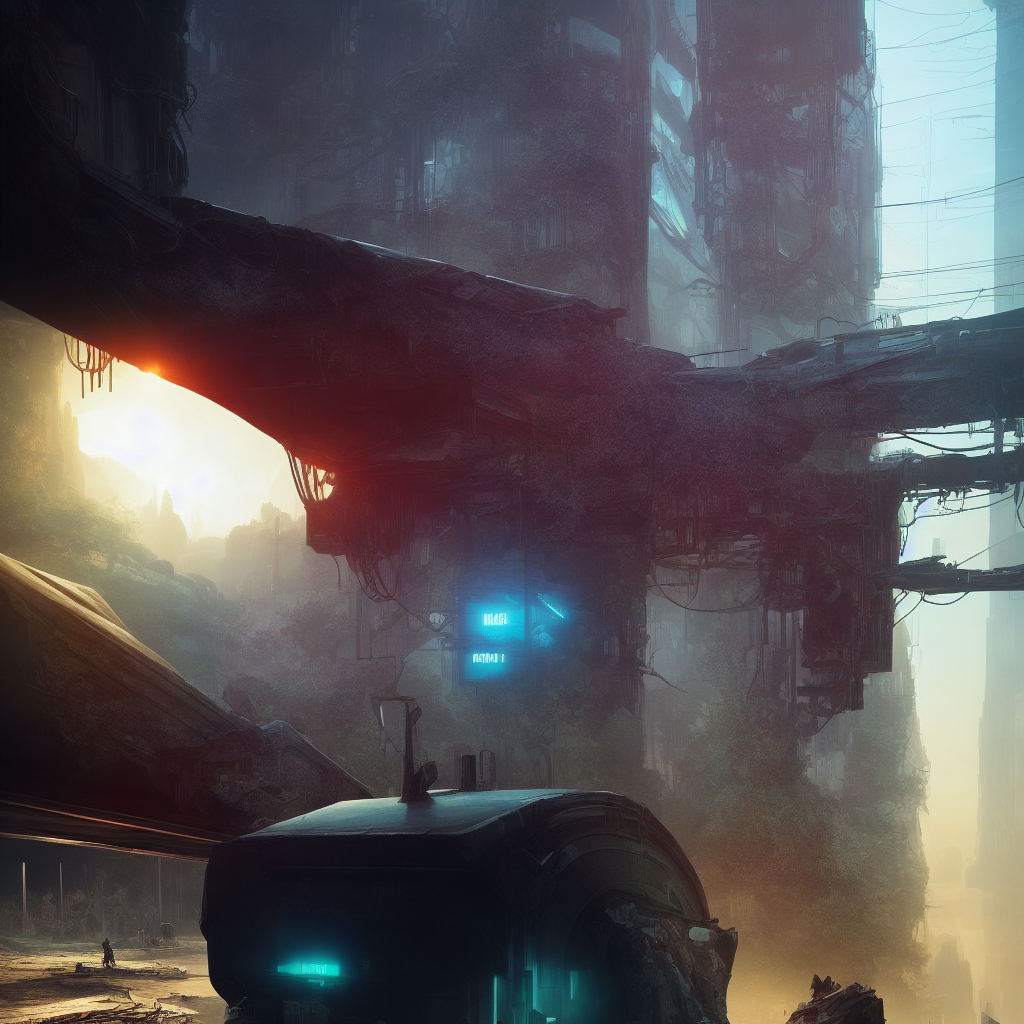

Global seed set to 3350915115


Rendering animation frame 304 of 1226
beautiful alien ecological landscape, very crisp, featured on artstation, digital art, extremely detailed, hyper-detailed, establishing shot, hyperrealistic, cinematic lighting, particles, unreal engine, intricate:1.2 cyberpunk city, very crisp, featured on artstation, digital art, extremely detailed, hyper-detailed, establishing shot, hyperrealistic, cinematic lighting, particles, unreal engine, intricate:0.37 post apocalypticc, very crisp, featured on artstation, digital art, extremely detailed, hyper-detailed, establishing shot, hyperrealistic, cinematic lighting, particles, unreal engine, intricate:1.1300000000000001 geometric, very crisp, featured on artstation, digital art, extremely detailed, hyper-detailed, establishing shot, hyperrealistic, cinematic lighting, particles, unreal engine, intricate:0.21000000000000002 floral, very crisp, featured on artstation, digital art, extremely detailed, hyper-detailed, establishing shot, hyperrealistic

Decoding image: 100%|████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.22it/s]


KeyboardInterrupt: 

In [5]:
# This is the audio values. The full process for creating audio-driven animations is in https://www.youtube.com/watch?v=exrDbTx6uJU&t=3s However, I copy the values in CSV format (instead of Disco Diffusion format) and conform it to this presentation in Sublime Text. (Pablx)
audio_bass = [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.02, 0.00, 0.02, 0.40, 0.87, 0.93, 0.88, 0.91, 0.80, 0.02, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.22, 0.45, 0.65, 0.90, 1.00, 1.00, 0.92, 0.93, 0.93, 0.45, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.06, 0.08, 0.00, 0.00, 0.22, 0.69, 0.80, 0.82, 0.80, 0.55, 0.03, 0.00, 0.00, 0.00, 0.00, 0.00, 0.06, 0.28, 0.56, 0.83, 0.89, 0.94, 0.88, 0.86, 0.86, 0.91, 0.34, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.22, 0.80, 0.90, 0.92, 0.87, 0.87, 0.13, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.11, 0.44, 0.62, 0.86, 0.97, 0.97, 0.96, 0.92, 0.88, 0.65, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.12, 0.72, 0.80, 0.81, 0.78, 0.65, 0.07, 0.00, 0.00, 0.00, 0.00, 0.00, 0.04, 0.25, 0.47, 0.65, 0.80, 0.86, 0.88, 0.87, 0.92, 0.93, 0.54, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.12, 0.72, 0.90, 0.92, 0.92, 0.89, 0.27, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.04, 0.36, 0.56, 0.81, 0.96, 0.97, 0.93, 0.93, 0.91, 0.78, 0.02, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.02, 0.65, 0.77, 0.80, 0.78, 0.72, 0.17, 0.00, 0.00, 0.00, 0.00, 0.00, 0.02, 0.19, 0.42, 0.75, 0.88, 0.96, 0.94, 0.88, 0.89, 0.92, 0.71, 0.01, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.03, 0.62, 0.85, 0.87, 0.90, 0.92, 0.45, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.02, 0.27, 0.52, 0.77, 0.91, 0.98, 0.94, 0.92, 0.91, 0.88, 0.11, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.43, 0.62, 0.70, 0.69, 0.65, 0.22, 0.00, 0.00, 0.00, 0.00, 0.00, 0.01, 0.07, 0.30, 0.54, 0.75, 0.81, 0.88, 0.85, 0.85, 0.78, 0.77, 0.06, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.04, 0.46, 0.69, 0.74, 0.75, 0.76, 0.58, 0.01, 0.00, 0.00, 0.00, 0.00, 0.00, 0.02, 0.17, 0.42, 0.70, 0.85, 0.85, 0.86, 0.84, 0.85, 0.83, 0.27, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.35, 0.61, 0.67, 0.67, 0.63, 0.33, 0.01, 0.00, 0.00, 0.00, 0.00, 0.01, 0.05, 0.22, 0.56, 0.81, 0.84, 0.86, 0.85, 0.86, 0.89, 0.87, 0.16, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.01, 0.29, 0.66, 0.68, 0.76, 0.72, 0.71, 0.03, 0.00, 0.00, 0.00, 0.00, 0.00, 0.01, 0.08, 0.33, 0.58, 0.82, 0.90, 0.84, 0.83, 0.84, 0.82, 0.42, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.01, 0.00, 0.00, 0.02, 0.19, 0.59, 0.68, 0.70, 0.70, 0.55, 0.03, 0.00, 0.00, 0.00, 0.00, 0.00, 0.04, 0.15, 0.48, 0.78, 0.85, 0.86, 0.84, 0.86, 0.87, 0.88, 0.34, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.01, 0.20, 0.60, 0.72, 0.71, 0.73, 0.73, 0.13, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.03, 0.26, 0.55, 0.77, 0.85, 0.76, 0.73, 0.77, 0.76, 0.59, 0.00, 0.00, 0.00, 0.00, 0.00, 0.02, 0.46, 0.01, 0.00, 0.00, 0.03, 0.32, 0.37, 0.37, 0.47, 0.34, 0.03, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.05, 0.39, 0.69, 0.81, 0.82, 0.81, 0.82, 0.83, 0.82, 0.45, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.06, 0.48, 0.65, 0.71, 0.71, 0.71, 0.28, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.01, 0.16, 0.48, 0.76, 0.83, 0.79, 0.73, 0.80, 0.75, 0.74, 0.03, 0.00, 0.00, 0.00, 0.00, 0.00, 0.18, 0.03, 0.00, 0.00, 0.01, 0.46, 0.55, 0.59, 0.62, 0.59, 0.12, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.08, 0.35, 0.67, 0.85, 0.86, 0.85, 0.88, 0.87, 0.87, 0.69, 0.01, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.01, 0.34, 0.66, 0.74, 0.73, 0.75, 0.73, 0.04, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.07, 0.32, 0.63, 0.83, 0.85, 0.84, 0.85, 0.86, 0.81, 0.46, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.19, 0.47, 0.54, 0.58, 0.54, 0.38, 0.01, 0.00, 0.00, 0.00, 0.00, 0.00, 0.03, 0.17, 0.48, 0.72, 0.82, 0.85, 0.83, 0.82, 0.81, 0.81, 0.39, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.15, 0.62, 0.70, 0.73, 0.75, 0.71, 0.16, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.05, 0.31, 0.57, 0.79, 0.88, 0.86, 0.80, 0.85, 0.83, 0.62, 0.01, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.04, 0.50, 0.60, 0.60, 0.60, 0.45, 0.05, 0.00, 0.00, 0.00, 0.00, 0.00, 0.03, 0.19, 0.42, 0.60, 0.79, 0.84, 0.86, 0.88, 0.88, 0.86, 0.57, 0.01, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.01, 0.10, 0.67, 0.78, 0.78, 0.76, 0.77, 0.31, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.05, 0.29, 0.54, 0.76, 0.87, 0.89, 0.87, 0.83, 0.84, 0.79, 0.05, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.01, 0.53, 0.62, 0.68, 0.67, 0.60, 0.13, 0.00, 0.00, 0.00, 0.00, 0.00, 0.02, 0.17, 0.38, 0.64, 0.78, 0.85, 0.87, 0.78, 0.79, 0.77, 0.62, 0.02, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.02, 0.46, 0.71, 0.75, 0.79, 0.73, 0.45, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.01, 0.20, 0.42, 0.71, 0.86, 0.88, 0.86, 0.85, 0.83, 0.84, 0.16, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.23, 0.51, 0.55, 0.57, 0.50, 0.15, 0.00, 0.00, 0.00, 0.00, 0.00, 0.01, 0.07, 0.18, 0.28, 0.38, 0.43, 0.50, 0.45, 0.52, 0.71, 0.71, 0.06, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]
audio_drums = [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.75, 0.71, 0.67, 0.43, 0.31, 0.09, 0.04, 0.03, 0.07, 0.02, 0.04, 0.01, 0.35, 0.92, 0.87, 0.48, 0.24, 0.02, 0.00, 0.00, 0.12, 0.17, 0.03, 0.02, 0.01, 0.92, 0.77, 0.69, 0.35, 0.09, 0.01, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.22, 0.06, 0.01, 0.01, 0.01, 0.01, 0.24, 0.81, 0.53, 0.95, 0.83, 0.50, 0.20, 0.02, 0.01, 0.00, 0.05, 0.13, 0.03, 0.02, 0.02, 0.82, 0.80, 0.67, 0.34, 0.10, 0.01, 0.01, 0.00, 0.00, 0.00, 0.00, 0.00, 0.16, 0.07, 0.03, 0.02, 0.30, 0.91, 0.79, 0.41, 0.19, 0.99, 0.77, 0.55, 0.29, 0.06, 0.01, 0.00, 0.02, 0.22, 0.03, 0.02, 0.01, 0.70, 0.83, 0.73, 0.36, 0.14, 0.04, 0.01, 0.00, 0.00, 0.00, 0.00, 0.00, 0.15, 0.06, 0.01, 0.01, 0.00, 0.00, 0.05, 0.89, 0.55, 0.97, 0.76, 0.62, 0.25, 0.05, 0.01, 0.00, 0.00, 0.12, 0.02, 0.02, 0.02, 0.63, 0.81, 0.77, 0.36, 0.15, 0.02, 0.01, 0.00, 0.00, 0.00, 0.00, 0.00, 0.12, 0.07, 0.02, 0.02, 0.02, 0.02, 0.00, 0.02, 0.01, 0.94, 0.78, 0.68, 0.34, 0.10, 0.01, 0.00, 0.00, 0.19, 0.04, 0.01, 0.01, 0.51, 0.79, 0.88, 0.36, 0.17, 0.04, 0.01, 0.00, 0.03, 0.01, 0.00, 0.00, 0.07, 0.08, 0.01, 0.01, 0.01, 0.03, 0.00, 0.78, 0.60, 0.84, 0.82, 0.71, 0.29, 0.10, 0.01, 0.00, 0.00, 0.12, 0.04, 0.02, 0.02, 0.41, 0.85, 0.83, 0.44, 0.18, 0.03, 0.01, 0.00, 0.02, 0.01, 0.00, 0.00, 0.06, 0.15, 0.03, 0.02, 0.01, 0.85, 0.80, 0.60, 0.20, 0.70, 0.84, 0.72, 0.35, 0.14, 0.01, 0.00, 0.00, 0.16, 0.06, 0.02, 0.01, 0.28, 0.91, 0.83, 0.46, 0.22, 0.06, 0.02, 0.00, 0.02, 0.03, 0.00, 0.00, 0.02, 0.13, 0.02, 0.01, 0.00, 0.04, 0.00, 0.60, 0.68, 0.74, 0.81, 0.80, 0.32, 0.13, 0.01, 0.00, 0.00, 0.15, 0.04, 0.03, 0.02, 0.22, 0.95, 0.75, 0.51, 0.21, 0.05, 0.01, 0.01, 0.01, 0.69, 0.57, 0.44, 0.24, 0.21, 0.04, 0.04, 0.03, 0.07, 0.02, 0.03, 0.02, 0.53, 0.80, 0.88, 0.39, 0.19, 0.01, 0.01, 0.00, 0.13, 0.06, 0.02, 0.01, 0.10, 1.00, 0.78, 0.56, 0.25, 0.05, 0.01, 0.01, 0.00, 0.04, 0.00, 0.01, 0.00, 0.22, 0.03, 0.02, 0.01, 0.06, 0.04, 0.44, 0.84, 0.65, 0.86, 0.86, 0.39, 0.16, 0.02, 0.02, 0.00, 0.13, 0.08, 0.02, 0.01, 0.04, 0.98, 0.76, 0.60, 0.29, 0.07, 0.01, 0.02, 0.00, 0.04, 0.00, 0.01, 0.00, 0.13, 0.05, 0.02, 0.00, 0.46, 0.84, 0.86, 0.30, 0.34, 0.93, 0.83, 0.44, 0.22, 0.03, 0.01, 0.00, 0.08, 0.16, 0.02, 0.02, 0.01, 0.89, 0.79, 0.65, 0.33, 0.09, 0.01, 0.02, 0.00, 0.04, 0.00, 0.01, 0.00, 0.21, 0.07, 0.03, 0.01, 0.06, 0.04, 0.22, 0.89, 0.59, 0.97, 0.80, 0.49, 0.20, 0.04, 0.01, 0.01, 0.03, 0.17, 0.01, 0.02, 0.00, 0.79, 0.81, 0.69, 0.35, 0.10, 0.01, 0.02, 0.00, 0.04, 0.00, 0.01, 0.00, 0.14, 0.05, 0.03, 0.01, 0.07, 0.04, 0.02, 0.01, 0.10, 0.96, 0.76, 0.55, 0.28, 0.06, 0.01, 0.01, 0.01, 0.21, 0.02, 0.02, 0.00, 0.68, 0.80, 0.77, 0.35, 0.11, 0.02, 0.02, 0.00, 0.04, 0.00, 0.01, 0.00, 0.18, 0.10, 0.03, 0.01, 0.04, 0.04, 0.07, 0.61, 0.56, 0.97, 0.76, 0.61, 0.24, 0.07, 0.01, 0.02, 0.00, 0.23, 0.02, 0.02, 0.00, 0.60, 0.79, 0.85, 0.35, 0.13, 0.01, 0.01, 0.00, 0.04, 0.01, 0.01, 0.00, 0.12, 0.10, 0.04, 0.01, 0.09, 0.96, 0.76, 0.55, 0.15, 0.89, 0.78, 0.64, 0.30, 0.08, 0.01, 0.01, 0.00, 0.22, 0.04, 0.02, 0.01, 0.49, 0.79, 0.89, 0.38, 0.17, 0.03, 0.02, 0.00, 0.03, 0.01, 0.01, 0.00, 0.09, 0.17, 0.02, 0.02, 0.01, 0.07, 0.04, 0.67, 0.63, 0.84, 0.80, 0.71, 0.29, 0.10, 0.01, 0.02, 0.00, 0.21, 0.05, 0.03, 0.01, 0.35, 0.88, 0.85, 0.44, 0.19, 0.02, 0.02, 0.01, 0.03, 0.02, 0.01, 0.01, 0.05, 0.14, 0.02, 0.03, 0.01, 0.09, 0.01, 0.02, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.69, 0.73, 0.67, 0.45, 0.36, 0.14, 0.06, 0.04, 0.09, 0.04, 0.04, 0.02, 0.28, 0.96, 0.84, 0.51, 0.22, 0.03, 0.01, 0.01, 0.07, 0.14, 0.03, 0.02, 0.01, 0.82, 0.81, 0.65, 0.33, 0.09, 0.01, 0.01, 0.00, 0.04, 0.00, 0.01, 0.00, 0.21, 0.05, 0.02, 0.01, 0.04, 0.03, 0.16, 0.83, 0.53, 0.99, 0.78, 0.52, 0.21, 0.05, 0.01, 0.01, 0.03, 0.18, 0.04, 0.04, 0.03, 0.75, 0.81, 0.66, 0.33, 0.12, 0.01, 0.02, 0.01, 0.03, 0.00, 0.02, 0.00, 0.15, 0.08, 0.04, 0.02, 0.23, 0.93, 0.76, 0.44, 0.17, 0.98, 0.77, 0.58, 0.28, 0.07, 0.01, 0.01, 0.00, 0.22, 0.03, 0.02, 0.02, 0.64, 0.81, 0.76, 0.34, 0.14, 0.04, 0.02, 0.00, 0.04, 0.01, 0.01, 0.00, 0.15, 0.07, 0.02, 0.01, 0.03, 0.04, 0.04, 0.81, 0.53, 0.94, 0.74, 0.65, 0.25, 0.07, 0.00, 0.02, 0.00, 0.19, 0.04, 0.04, 0.02, 0.57, 0.78, 0.80, 0.36, 0.14, 0.02, 0.01, 0.00, 0.03, 0.01, 0.01, 0.00, 0.11, 0.09, 0.04, 0.02, 0.03, 0.08, 0.02, 0.03, 0.00, 0.86, 0.82, 0.67, 0.34, 0.11, 0.01, 0.01, 0.00, 0.20, 0.05, 0.02, 0.01, 0.42, 0.83, 0.87, 0.39, 0.18, 0.05, 0.02, 0.00, 0.03, 0.02, 0.01, 0.01, 0.08, 0.14, 0.02, 0.01, 0.00, 0.06, 0.02, 0.69, 0.60, 0.80, 0.83, 0.71, 0.29, 0.11, 0.01, 0.02, 0.00, 0.17, 0.06, 0.04, 0.02, 0.34, 0.90, 0.81, 0.44, 0.19, 0.03, 0.01, 0.01, 0.02, 0.02, 0.01, 0.01, 0.03, 0.15, 0.03, 0.02, 0.01, 0.79, 0.78, 0.64, 0.22, 0.67, 0.82, 0.76, 0.33, 0.13, 0.01, 0.01, 0.00, 0.18, 0.06, 0.02, 0.01, 0.22, 0.92, 0.80, 0.49, 0.21, 0.03, 0.02, 0.01, 0.01, 0.04, 0.00, 0.01, 0.01, 0.20, 0.01, 0.02, 0.00, 0.06, 0.03, 0.51, 0.68, 0.72, 0.80, 0.85, 0.32, 0.14, 0.01, 0.02, 0.00, 0.16, 0.05, 0.03, 0.02, 0.13, 0.98, 0.73, 0.56, 0.23, 0.05, 0.01, 0.01, 0.00, 0.03, 0.00, 0.01, 0.00, 0.17, 0.04, 0.04, 0.01, 0.08, 0.02, 0.02, 0.00, 0.00, 0.05, 0.04, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]
audio_other = [0.00, 0.00, 0.00, 0.01, 0.02, 0.04, 0.05, 0.05, 0.04, 0.04, 0.02, 0.02, 0.03, 0.02, 0.02, 0.01, 0.01, 0.47, 0.68, 0.51, 0.47, 0.43, 0.39, 0.36, 0.32, 0.27, 0.26, 0.24, 0.21, 0.20, 0.18, 0.16, 0.13, 0.11, 0.12, 0.12, 0.12, 0.11, 0.10, 0.10, 0.08, 0.06, 0.05, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.28, 0.35, 0.37, 0.34, 0.31, 0.25, 0.22, 0.20, 0.19, 0.16, 0.14, 0.13, 0.23, 0.66, 0.51, 0.47, 0.44, 0.44, 0.46, 0.44, 0.43, 0.37, 0.36, 0.34, 0.33, 0.32, 0.30, 0.30, 0.29, 0.28, 0.26, 0.23, 0.22, 0.40, 0.78, 0.58, 0.52, 0.50, 0.42, 0.36, 0.35, 0.33, 0.30, 0.27, 0.25, 0.21, 0.19, 0.16, 0.14, 0.14, 0.16, 0.16, 0.15, 0.13, 0.12, 0.11, 0.10, 0.11, 0.09, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.10, 0.24, 0.38, 0.39, 0.34, 0.32, 0.28, 0.27, 0.24, 0.24, 0.19, 0.18, 0.18, 0.24, 0.67, 0.57, 0.51, 0.52, 0.47, 0.45, 0.44, 0.39, 0.15, 0.00, 0.00, 0.00, 0.01, 0.00, 0.00, 0.00, 0.00, 0.01, 0.00, 0.00, 0.01, 0.00, 0.06, 0.23, 0.29, 0.25, 0.21, 0.21, 0.22, 0.02, 0.01, 0.01, 0.01, 0.01, 0.00, 0.03, 0.13, 0.22, 0.20, 0.15, 0.14, 0.15, 0.15, 0.16, 0.15, 0.09, 0.02, 0.01, 0.00, 0.00, 0.00, 0.01, 0.01, 0.01, 0.00, 0.03, 0.20, 0.31, 0.37, 0.46, 0.47, 0.83, 0.08, 0.01, 0.01, 0.01, 0.01, 0.01, 0.07, 0.27, 0.30, 0.27, 0.24, 0.27, 0.23, 0.22, 0.20, 0.30, 0.39, 0.01, 0.01, 0.01, 0.01, 0.00, 0.00, 0.01, 0.01, 0.01, 0.03, 0.16, 0.22, 0.25, 0.20, 0.19, 0.23, 0.06, 0.01, 0.01, 0.01, 0.01, 0.00, 0.06, 0.28, 0.16, 0.17, 0.14, 0.13, 0.15, 0.15, 0.17, 0.18, 0.12, 0.02, 0.01, 0.00, 0.01, 0.01, 0.01, 0.01, 0.01, 0.00, 0.02, 0.14, 0.23, 0.32, 0.43, 0.47, 0.76, 0.28, 0.01, 0.00, 0.01, 0.01, 0.00, 0.03, 0.20, 0.24, 0.17, 0.18, 0.18, 0.21, 0.22, 0.24, 0.22, 0.36, 0.01, 0.01, 0.01, 0.04, 0.03, 0.01, 0.01, 0.01, 0.01, 0.02, 0.14, 0.21, 0.22, 0.21, 0.19, 0.22, 0.13, 0.01, 0.01, 0.00, 0.01, 0.01, 0.03, 0.22, 0.21, 0.20, 0.18, 0.15, 0.17, 0.17, 0.18, 0.20, 0.17, 0.02, 0.01, 0.00, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.11, 0.24, 0.31, 0.41, 0.47, 0.66, 0.46, 0.01, 0.01, 0.00, 0.01, 0.01, 0.02, 0.17, 0.28, 0.27, 0.24, 0.25, 0.25, 0.22, 0.25, 0.28, 0.55, 0.07, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.12, 0.23, 0.25, 0.25, 0.20, 0.22, 0.17, 0.03, 0.01, 0.00, 0.01, 0.01, 0.02, 0.24, 0.30, 0.23, 0.20, 0.16, 0.19, 0.20, 0.21, 0.22, 0.24, 0.12, 0.04, 0.04, 0.04, 0.04, 0.03, 0.02, 0.01, 0.02, 0.03, 0.09, 0.34, 0.58, 0.68, 0.79, 0.79, 0.71, 0.23, 0.34, 0.30, 0.20, 0.05, 0.10, 0.27, 0.45, 0.36, 0.23, 0.22, 0.26, 0.19, 0.14, 0.19, 0.41, 0.27, 0.03, 0.00, 0.00, 0.01, 0.01, 0.01, 0.00, 0.05, 0.00, 0.04, 0.23, 0.38, 0.32, 0.28, 0.26, 0.31, 0.14, 0.01, 0.00, 0.01, 0.00, 0.00, 0.01, 0.18, 0.26, 0.22, 0.18, 0.21, 0.21, 0.21, 0.22, 0.22, 0.17, 0.05, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.00, 0.03, 0.26, 0.50, 0.60, 0.67, 0.65, 0.79, 0.45, 0.32, 0.25, 0.22, 0.01, 0.01, 0.20, 0.55, 0.64, 0.61, 0.51, 0.55, 0.55, 0.48, 0.49, 0.62, 0.73, 0.49, 0.49, 0.35, 0.24, 0.01, 0.01, 0.07, 0.11, 0.00, 0.04, 0.27, 0.47, 0.41, 0.37, 0.36, 0.39, 0.25, 0.03, 0.01, 0.01, 0.01, 0.01, 0.01, 0.33, 0.55, 0.46, 0.36, 0.33, 0.33, 0.31, 0.32, 0.37, 0.30, 0.09, 0.01, 0.00, 0.01, 0.00, 0.02, 0.08, 0.01, 0.00, 0.02, 0.27, 0.53, 0.61, 0.69, 0.69, 0.91, 0.36, 0.18, 0.19, 0.20, 0.02, 0.01, 0.15, 0.53, 0.60, 0.61, 0.51, 0.51, 0.55, 0.47, 0.48, 0.55, 0.67, 0.35, 0.40, 0.41, 0.34, 0.16, 0.15, 0.10, 0.14, 0.08, 0.09, 0.21, 0.45, 0.41, 0.36, 0.37, 0.43, 0.24, 0.04, 0.01, 0.02, 0.04, 0.05, 0.02, 0.26, 0.61, 0.55, 0.43, 0.36, 0.38, 0.37, 0.36, 0.40, 0.33, 0.13, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.23, 0.73, 0.85, 0.90, 0.84, 0.99, 0.50, 0.26, 0.27, 0.24, 0.07, 0.01, 0.09, 0.54, 0.64, 0.71, 0.57, 0.58, 0.66, 0.62, 0.64, 0.66, 0.76, 0.39, 0.37, 0.25, 0.25, 0.01, 0.00, 0.03, 0.14, 0.01, 0.01, 0.14, 0.49, 0.51, 0.43, 0.41, 0.46, 0.34, 0.10, 0.01, 0.01, 0.01, 0.01, 0.01, 0.16, 0.62, 0.59, 0.46, 0.35, 0.36, 0.37, 0.32, 0.36, 0.35, 0.25, 0.06, 0.04, 0.05, 0.05, 0.04, 0.02, 0.04, 0.03, 0.04, 0.13, 0.49, 0.64, 0.70, 0.72, 0.80, 0.67, 0.39, 0.47, 0.41, 0.22, 0.07, 0.08, 0.44, 0.59, 0.63, 0.50, 0.47, 0.56, 0.52, 0.52, 0.54, 0.74, 0.70, 0.82, 0.72, 0.70, 0.45, 0.38, 0.43, 0.56, 0.62, 0.75, 0.61, 0.71, 0.73, 0.53, 0.48, 0.50, 0.44, 0.38, 0.39, 0.37, 0.34, 0.24, 0.22, 0.25, 0.23, 0.24, 0.21, 0.21, 0.22, 0.18, 0.15, 0.16, 0.13, 0.11, 0.10, 0.10, 0.10, 0.08, 0.07, 0.07, 0.07, 0.27, 0.36, 0.36, 0.32, 0.30, 0.26, 0.24, 0.22, 0.20, 0.17, 0.15, 0.14, 0.19, 0.67, 0.51, 0.50, 0.47, 0.48, 0.44, 0.41, 0.39, 0.35, 0.37, 0.33, 0.35, 0.34, 0.33, 0.32, 0.30, 0.27, 0.25, 0.22, 0.22, 0.39, 0.78, 0.63, 0.54, 0.52, 0.46, 0.42, 0.36, 0.30, 0.29, 0.28, 0.27, 0.25, 0.22, 0.20, 0.18, 0.19, 0.21, 0.25, 0.20, 0.17, 0.17, 0.16, 0.15, 0.15, 0.15, 0.13, 0.15, 0.13, 0.12, 0.14, 0.12, 0.16, 0.26, 0.40, 0.42, 0.36, 0.35, 0.31, 0.30, 0.27, 0.27, 0.25, 0.26, 0.26, 0.28, 0.68, 0.62, 0.58, 0.52, 0.48, 0.50, 0.52, 0.47, 0.19, 0.01, 0.00, 0.00, 0.01, 0.00, 0.00, 0.01, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.03, 0.23, 0.35, 0.27, 0.29, 0.28, 0.26, 0.03, 0.01, 0.01, 0.01, 0.01, 0.01, 0.04, 0.36, 0.42, 0.29, 0.23, 0.23, 0.24, 0.23, 0.23, 0.25, 0.16, 0.01, 0.00, 0.00, 0.01, 0.01, 0.01, 0.01, 0.01, 0.00, 0.02, 0.21, 0.59, 0.70, 0.78, 0.76, 1.00, 0.14, 0.02, 0.01, 0.01, 0.01, 0.00, 0.07, 0.45, 0.46, 0.44, 0.35, 0.42, 0.36, 0.37, 0.38, 0.58, 0.57, 0.06, 0.01, 0.00, 0.01, 0.01, 0.00, 0.00, 0.01, 0.00, 0.02, 0.17, 0.38, 0.35, 0.36, 0.36, 0.36, 0.09, 0.01, 0.01, 0.01, 0.01, 0.00, 0.01, 0.31, 0.36, 0.26, 0.22, 0.23, 0.24, 0.24, 0.24, 0.25, 0.20, 0.01, 0.01, 0.00, 0.00, 0.00, 0.01, 0.01, 0.01, 0.01, 0.01, 0.14, 0.49, 0.59, 0.71, 0.70, 0.88, 0.33, 0.02, 0.01, 0.01, 0.01, 0.00, 0.03, 0.26, 0.33, 0.20, 0.19, 0.20, 0.21, 0.24, 0.30, 0.37, 0.51, 0.01, 0.01, 0.01, 0.01, 0.01, 0.00, 0.01, 0.01, 0.01, 0.01, 0.09, 0.16, 0.18, 0.16, 0.18, 0.22, 0.13, 0.01, 0.01, 0.01, 0.01, 0.01, 0.00, 0.07, 0.17, 0.15, 0.11, 0.10, 0.14, 0.14, 0.12, 0.11, 0.13, 0.01, 0.01, 0.00, 0.00, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.09, 0.38, 0.55, 0.68, 0.73, 0.82, 0.53, 0.02, 0.01, 0.01, 0.01, 0.00, 0.01, 0.23, 0.35, 0.34, 0.30, 0.27, 0.32, 0.26, 0.29, 0.36, 0.65, 0.12, 0.01, 0.00, 0.01, 0.01, 0.00, 0.00, 0.00, 0.01, 0.01, 0.09, 0.29, 0.34, 0.27, 0.23, 0.22, 0.17, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.09, 0.24, 0.27, 0.19, 0.13, 0.16, 0.16, 0.15, 0.14, 0.13, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.02, 0.01, 0.05, 0.45, 0.52, 0.59, 0.62, 0.72, 0.75, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.22, 0.46, 0.47, 0.55, 0.64, 0.60, 0.67, 0.64, 0.40, 0.48, 0.18, 0.01, 0.01, 0.03, 0.02, 0.03, 0.02, 0.03, 0.37, 0.75, 0.55, 0.49, 0.46, 0.42, 0.40, 0.33, 0.28, 0.25, 0.23, 0.21, 0.21, 0.19, 0.18, 0.16, 0.14, 0.12, 0.10, 0.09, 0.09, 0.09, 0.08, 0.08, 0.07, 0.06, 0.05, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.17, 0.37, 0.37, 0.33, 0.30, 0.26, 0.23, 0.21, 0.18, 0.17, 0.15, 0.14, 0.13, 0.61, 0.57, 0.48, 0.46, 0.42, 0.45, 0.40, 0.41, 0.36, 0.34, 0.33, 0.30, 0.32, 0.33, 0.32, 0.31, 0.28, 0.26, 0.23, 0.21, 0.26, 0.78, 0.64, 0.52, 0.50, 0.47, 0.44, 0.39, 0.33, 0.29, 0.24, 0.22, 0.21, 0.20, 0.19, 0.17, 0.16, 0.14, 0.13, 0.10, 0.09, 0.09, 0.09, 0.08, 0.08, 0.08, 0.07, 0.07, 0.07, 0.06, 0.06, 0.05, 0.06, 0.10, 0.40, 0.38, 0.33, 0.32, 0.27, 0.24, 0.22, 0.21, 0.18, 0.16, 0.14, 0.14, 0.52, 0.61, 0.50, 0.49, 0.45, 0.40, 0.39, 0.33, 0.31, 0.29, 0.29, 0.29, 0.26, 0.24, 0.21, 0.18, 0.15, 0.14, 0.13, 0.12, 0.11, 0.09, 0.07, 0.05, 0.04, 0.03, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]
audio_voice = [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.03, 0.12, 0.13, 0.19, 0.21, 0.21, 0.23, 0.26, 0.25, 0.19, 0.19, 0.20, 0.26, 0.17, 0.18, 0.15, 0.21, 0.13, 0.34, 0.36, 0.29, 0.21, 0.10, 0.11, 0.18, 0.06, 0.05, 0.03, 0.04, 0.03, 0.02, 0.01, 0.03, 0.03, 0.20, 0.30, 0.21, 0.21, 0.19, 0.20, 0.21, 0.18, 0.02, 0.00, 0.00, 0.02, 0.01, 0.00, 0.00, 0.00, 0.02, 0.20, 0.24, 0.20, 0.15, 0.06, 0.15, 0.20, 0.04, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.00, 0.05, 0.13, 0.15, 0.17, 0.07, 0.06, 0.07, 0.08, 0.02, 0.02, 0.02, 0.04, 0.05, 0.06, 0.04, 0.02, 0.02, 0.23, 0.32, 0.22, 0.21, 0.06, 0.07, 0.14, 0.12, 0.01, 0.01, 0.01, 0.00, 0.00, 0.00, 0.00, 0.00, 0.15, 0.32, 0.25, 0.23, 0.19, 0.21, 0.21, 0.21, 0.04, 0.00, 0.00, 0.00, 0.01, 0.00, 0.00, 0.00, 0.01, 0.19, 0.25, 0.17, 0.09, 0.04, 0.10, 0.20, 0.06, 0.00, 0.00, 0.01, 0.01, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.01, 0.00, 0.01, 0.02, 0.01, 0.03, 0.69, 0.70, 0.54, 0.63, 0.14, 0.14, 0.28, 0.34, 0.05, 0.05, 0.03, 0.03, 0.04, 0.02, 0.03, 0.01, 0.20, 0.65, 0.62, 0.54, 0.53, 0.53, 0.50, 0.35, 0.13, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.02, 0.53, 0.59, 0.58, 0.47, 0.15, 0.18, 0.37, 0.25, 0.05, 0.20, 0.29, 0.15, 0.29, 0.32, 0.27, 0.17, 0.25, 0.46, 0.40, 0.40, 0.33, 0.09, 0.16, 0.33, 0.25, 0.00, 0.00, 0.02, 0.04, 0.04, 0.05, 0.04, 0.01, 0.51, 0.68, 0.56, 0.59, 0.25, 0.13, 0.21, 0.18, 0.05, 0.06, 0.04, 0.03, 0.05, 0.03, 0.04, 0.03, 0.14, 0.61, 0.62, 0.54, 0.53, 0.52, 0.51, 0.35, 0.15, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.01, 0.51, 0.58, 0.57, 0.50, 0.23, 0.14, 0.33, 0.34, 0.19, 0.49, 0.37, 0.33, 0.30, 0.34, 0.35, 0.34, 0.19, 0.50, 0.47, 0.51, 0.47, 0.20, 0.31, 0.54, 0.70, 0.04, 0.00, 0.02, 0.05, 0.05, 0.05, 0.07, 0.03, 0.48, 0.60, 0.61, 0.57, 0.34, 0.11, 0.18, 0.16, 0.03, 0.08, 0.05, 0.04, 0.05, 0.03, 0.04, 0.03, 0.08, 0.57, 0.65, 0.53, 0.55, 0.52, 0.51, 0.39, 0.24, 0.01, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.43, 0.55, 0.59, 0.51, 0.33, 0.11, 0.29, 0.38, 0.08, 0.14, 0.26, 0.18, 0.22, 0.35, 0.28, 0.25, 0.12, 0.48, 0.42, 0.38, 0.42, 0.12, 0.13, 0.23, 0.25, 0.02, 0.02, 0.03, 0.05, 0.04, 0.05, 0.06, 0.03, 0.33, 0.62, 0.64, 0.53, 0.44, 0.11, 0.16, 0.21, 0.06, 0.10, 0.07, 0.05, 0.06, 0.05, 0.05, 0.07, 0.05, 0.50, 0.67, 0.53, 0.53, 0.52, 0.52, 0.43, 0.33, 0.06, 0.04, 0.05, 0.03, 0.03, 0.03, 0.03, 0.04, 0.15, 0.38, 0.30, 0.29, 0.26, 0.09, 0.18, 0.39, 0.13, 0.38, 0.41, 0.36, 0.25, 0.30, 0.28, 0.29, 0.16, 0.02, 0.00, 0.01, 0.01, 0.01, 0.01, 0.01, 0.00, 0.01, 0.00, 0.06, 0.49, 0.42, 0.43, 0.33, 0.41, 0.33, 0.28, 0.30, 0.53, 0.48, 0.02, 0.03, 0.24, 0.40, 0.29, 0.34, 0.40, 0.35, 0.36, 0.30, 0.31, 0.25, 0.21, 0.23, 0.26, 0.25, 0.24, 0.24, 0.19, 0.16, 0.08, 0.01, 0.02, 0.12, 0.15, 0.12, 0.12, 0.17, 0.15, 0.11, 0.18, 0.19, 0.17, 0.01, 0.01, 0.06, 0.15, 0.10, 0.06, 0.03, 0.03, 0.02, 0.06, 0.07, 0.07, 0.10, 0.22, 0.21, 0.16, 0.08, 0.01, 0.03, 0.16, 0.16, 0.00, 0.03, 0.36, 0.41, 0.35, 0.31, 0.41, 0.37, 0.37, 0.48, 0.58, 0.56, 0.08, 0.03, 0.18, 0.33, 0.33, 0.42, 0.48, 0.35, 0.30, 0.29, 0.37, 0.24, 0.20, 0.23, 0.28, 0.25, 0.23, 0.26, 0.23, 0.16, 0.10, 0.01, 0.01, 0.08, 0.13, 0.12, 0.10, 0.15, 0.17, 0.17, 0.27, 0.28, 0.23, 0.03, 0.01, 0.04, 0.19, 0.17, 0.11, 0.07, 0.05, 0.06, 0.09, 0.13, 0.12, 0.19, 0.42, 0.39, 0.27, 0.26, 0.17, 0.20, 0.35, 0.41, 0.14, 0.16, 0.30, 0.41, 0.34, 0.32, 0.41, 0.40, 0.37, 0.55, 0.62, 0.69, 0.23, 0.07, 0.19, 0.36, 0.36, 0.47, 0.52, 0.41, 0.34, 0.37, 0.45, 0.33, 0.25, 0.32, 0.32, 0.30, 0.30, 0.33, 0.28, 0.22, 0.17, 0.02, 0.02, 0.07, 0.15, 0.15, 0.12, 0.17, 0.17, 0.16, 0.18, 0.23, 0.22, 0.07, 0.01, 0.03, 0.17, 0.17, 0.15, 0.07, 0.03, 0.03, 0.06, 0.12, 0.15, 0.10, 0.21, 0.31, 0.22, 0.20, 0.01, 0.02, 0.11, 0.25, 0.02, 0.01, 0.19, 0.51, 0.36, 0.33, 0.42, 0.42, 0.34, 0.58, 0.58, 0.69, 0.33, 0.03, 0.10, 0.32, 0.38, 0.42, 0.49, 0.44, 0.32, 0.37, 0.42, 0.35, 0.25, 0.28, 0.29, 0.29, 0.28, 0.30, 0.23, 0.23, 0.18, 0.04, 0.05, 0.08, 0.18, 0.16, 0.13, 0.18, 0.16, 0.11, 0.04, 0.05, 0.07, 0.05, 0.02, 0.03, 0.10, 0.12, 0.07, 0.03, 0.01, 0.02, 0.02, 0.03, 0.04, 0.02, 0.08, 0.05, 0.01, 0.00, 0.00, 0.00, 0.00, 0.01, 0.05, 0.08, 0.02, 0.03, 0.05, 0.04, 0.04, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.00, 0.00, 0.00, 0.01, 0.00, 0.01, 0.01, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.01, 0.01, 0.01, 0.01, 0.01, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.01, 0.20, 0.44, 0.46, 0.35, 0.43, 0.45, 0.89, 1.00, 0.90, 0.99, 0.22, 0.15, 0.34, 0.56, 0.30, 0.41, 0.39, 0.40, 0.39, 0.34, 0.32, 0.30, 0.37, 0.78, 0.74, 0.62, 0.64, 0.66, 0.63, 0.45, 0.23, 0.01, 0.01, 0.02, 0.04, 0.05, 0.03, 0.04, 0.03, 0.66, 0.82, 0.60, 0.52, 0.19, 0.17, 0.37, 0.28, 0.06, 0.21, 0.30, 0.17, 0.29, 0.37, 0.31, 0.21, 0.20, 0.46, 0.41, 0.41, 0.36, 0.10, 0.16, 0.32, 0.27, 0.01, 0.02, 0.28, 0.58, 0.46, 0.34, 0.39, 0.46, 0.55, 0.79, 0.75, 0.91, 0.36, 0.13, 0.23, 0.46, 0.30, 0.36, 0.35, 0.39, 0.36, 0.36, 0.29, 0.32, 0.29, 0.71, 0.70, 0.59, 0.62, 0.63, 0.64, 0.46, 0.30, 0.05, 0.08, 0.07, 0.06, 0.06, 0.04, 0.06, 0.05, 0.54, 0.81, 0.61, 0.53, 0.30, 0.15, 0.33, 0.36, 0.18, 0.53, 0.40, 0.40, 0.34, 0.38, 0.41, 0.40, 0.22, 0.61, 0.60, 0.68, 0.70, 0.32, 0.41, 0.69, 0.86, 0.08, 0.01, 0.14, 0.56, 0.47, 0.37, 0.39, 0.49, 0.60, 0.86, 0.85, 0.89, 0.53, 0.12, 0.18, 0.52, 0.45, 0.34, 0.37, 0.41, 0.37, 0.37, 0.31, 0.34, 0.27, 0.66, 0.73, 0.58, 0.61, 0.61, 0.61, 0.48, 0.38, 0.05, 0.00, 0.01, 0.04, 0.06, 0.06, 0.05, 0.05, 0.42, 0.73, 0.67, 0.55, 0.38, 0.11, 0.29, 0.40, 0.07, 0.15, 0.25, 0.24, 0.22, 0.37, 0.35, 0.27, 0.11, 0.51, 0.44, 0.40, 0.43, 0.15, 0.13, 0.22, 0.42, 0.03, 0.01, 0.09, 0.61, 0.49, 0.44, 0.38, 0.51, 0.43, 0.81, 0.77, 0.84, 0.68, 0.12, 0.16, 0.45, 0.44, 0.30, 0.38, 0.42, 0.37, 0.39, 0.32, 0.34, 0.26, 0.57, 0.76, 0.62, 0.61, 0.61, 0.64, 0.54, 0.42, 0.10, 0.07, 0.07, 0.08, 0.09, 0.08, 0.07, 0.11, 0.21, 0.72, 0.67, 0.56, 0.45, 0.11, 0.26, 0.41, 0.19, 0.43, 0.42, 0.36, 0.31, 0.38, 0.41, 0.43, 0.30, 0.48, 0.57, 0.63, 0.70, 0.53, 0.39, 0.55, 0.82, 0.46, 0.18, 0.16, 0.25, 0.16, 0.15, 0.11, 0.17, 0.10, 0.08, 0.08, 0.11, 0.08, 0.07, 0.07, 0.09, 0.09, 0.05, 0.05, 0.06, 0.07, 0.05, 0.05, 0.05, 0.07, 0.04, 0.04, 0.05, 0.05, 0.04, 0.04, 0.04, 0.05, 0.02, 0.02, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]
audio_metronome = [0,0,0,0,0,0,0,0,0.8,0.26,0.06,0,0,0,0,0,0,0.97,0.13,0.02,0,0,0,0,0,0,0.97,0.13,0.02,0,0,0,0,0,0.97,0.13,0.03,0,0,0,0,0,0.96,0.13,0.04,0,0,0,0,0,0.93,0.14,0.05,0,0,0,0,0,0.7,0.34,0.08,0.01,0,0,0,0,0,1,0.11,0.02,0,0,0,0,0,0.9,0.17,0.05,0,0,0,0,0,0.89,0.19,0.05,0,0,0,0,0,0.54,0.48,0.09,0.01,0,0,0,0,0.83,0.24,0.06,0,0,0,0,0,0,0.94,0.13,0.05,0,0,0,0,0,0.8,0.26,0.06,0,0,0,0,0,0.02,0.99,0.1,0.02,0,0,0,0,0,1,0.11,0.02,0,0,0,0,0,0.96,0.13,0.04,0,0,0,0,0,0.89,0.19,0.05,0,0,0,0,0,0.7,0.34,0.08,0.01,0,0,0,0,0.83,0.24,0.06,0,0,0,0,0,0,0.94,0.13,0.05,0,0,0,0,0,0.8,0.26,0.06,0,0,0,0,0,0.54,0.48,0.09,0.01,0,0,0,0,0,0.95,0.13,0.05,0,0,0,0,0,0.9,0.17,0.05,0,0,0,0,0,0.64,0.39,0.08,0.01,0,0,0,0,0.02,0.99,0.1,0.02,0,0,0,0,0.67,0.37,0.08,0.01,0,0,0,0,0,0.9,0.17,0.05,0,0,0,0,0,0.64,0.39,0.08,0.01,0,0,0,0,0.02,0.99,0.1,0.02,0,0,0,0,0,0.77,0.29,0.07,0,0,0,0,0,0.83,0.24,0.06,0,0,0,0,0,0.15,0.86,0.1,0.01,0,0,0,0,0,0.97,0.13,0.02,0,0,0,0,0,0.91,0.16,0.05,0,0,0,0,0,0.74,0.31,0.07,0.01,0,0,0,0,0,0.99,0.12,0.02,0,0,0,0,0,0.95,0.13,0.04,0,0,0,0,0,0.77,0.29,0.07,0,0,0,0,0,0.67,0.37,0.08,0.01,0,0,0,0,0,0.96,0.13,0.04,0,0,0,0,0,0.93,0.14,0.05,0,0,0,0,0,0.77,0.29,0.07,0,0,0,0,0,0.36,0.66,0.09,0.01,0,0,0,0,0,0.94,0.13,0.05,0,0,0,0,0,0.88,0.19,0.05,0,0,0,0,0,0.02,0.99,0.1,0.02,0,0,0,0,0,0.97,0.13,0.03,0,0,0,0,0,0.94,0.13,0.05,0,0,0,0,0,0.8,0.26,0.06,0,0,0,0,0,0.54,0.48,0.09,0.01,0,0,0,0,0,0.97,0.13,0.03,0,0,0,0,0,0.9,0.17,0.05,0,0,0,0,0,0.72,0.33,0.07,0.01,0,0,0,0,0.02,0.99,0.1,0.02,0,0,0,0,0,0.97,0.13,0.03,0,0,0,0,0,0.74,0.31,0.07,0.01,0,0,0,0,0.72,0.33,0.07,0.01,0,0,0,0,0,0.97,0.13,0.02,0,0,0,0,0,0.95,0.13,0.05,0,0,0,0,0,0.74,0.31,0.07,0.01,0,0,0,0,0.64,0.39,0.08,0.01,0,0,0,0,0,0.95,0.13,0.04,0,0,0,0,0,0.91,0.16,0.05,0,0,0,0,0,0.67,0.37,0.08,0.01,0,0,0,0,0.15,0.86,0.1,0.01,0,0,0,0,0,0.93,0.14,0.05,0,0,0,0,0,0.86,0.21,0.06,0,0,0,0,0,0.36,0.66,0.09,0.01,0,0,0,0,0,0.99,0.12,0.02,0,0,0,0,0,0.89,0.19,0.05,0,0,0,0,0,0.77,0.29,0.07,0,0,0,0,0,0,1,0.11,0.02,0,0,0,0,0,0.96,0.13,0.04,0,0,0,0,0,0.89,0.19,0.05,0,0,0,0,0,0.7,0.34,0.08,0.01,0,0,0,0,0,0.97,0.13,0.03,0,0,0,0,0,0.94,0.13,0.05,0,0,0,0,0,0.8,0.26,0.06,0,0,0,0,0,0.54,0.48,0.09,0.01,0,0,0,0,0,0.95,0.13,0.05,0,0,0,0,0,0.9,0.17,0.05,0,0,0,0,0,0.64,0.39,0.08,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.8,0.26,0.06,0,0,0,0,0,0,0.97,0.13,0.02,0,0,0,0,0,0,0.97,0.13,0.02,0,0,0,0,0,0.97,0.13,0.03,0,0,0,0,0,0.96,0.13,0.04,0,0,0,0,0,0.93,0.14,0.05,0,0,0,0,0,0.7,0.34,0.08,0.01,0,0,0,0,0,1,0.11,0.02,0,0,0,0,0,0.9,0.17,0.05,0,0,0,0,0,0.89,0.19,0.05,0,0,0,0,0,0.54,0.48,0.09,0.01,0,0,0,0,0.83,0.24,0.06,0,0,0,0,0,0,0.94,0.13,0.05,0,0,0,0,0,0.8,0.26,0.06,0,0,0,0,0,0.02,0.99,0.1,0.02,0,0,0,0,0,1,0.11,0.02,0,0,0,0,0,0.96,0.13,0.04,0,0,0,0,0,0.89,0.19,0.05,0,0,0,0,0,0.7,0.34,0.08,0.01,0,0,0,0,0.83,0.24,0.06,0,0,0,0,0,0,0.94,0.13,0.05,0,0,0,0,0,0.8,0.26,0.06,0,0,0,0,0,0.54,0.48,0.09,0.01,0,0,0,0,0,0.95,0.13,0.05,0,0,0,0,0,0.9,0.17,0.05,0,0,0,0,0,0.64,0.39,0.08,0.01,0,0,0,0,0.02,0.99,0.1,0.02,0,0,0,0,0.67,0.37,0.08,0.01,0,0,0,0,0,0.9,0.17,0.05,0,0,0,0,0,0.64,0.39,0.08,0.01,0,0,0,0,0.02,0.99,0.1,0.02,0,0,0,0,0,0.77,0.29,0.07,0,0,0,0,0,0.83,0.24,0.06,0,0,0,0,0,0.15,0.86,0.1,0.01,0,0,0,0,0,0.97,0.13,0.02,0,0,0,0,0,0.91,0.16,0.05,0,0,0,0,0,0.74,0.31,0.07,0.01,0,0,0,0,0,0.99,0.12,0.02,0,0,0,0,0,0.95,0.13,0.04,0,0,0,0,0,0.77,0.29,0.07,0,0,0,0,0,0.67,0.37,0.08,0.01,0,0,0,0,0,0.96,0.13,0.04,0,0,0,0,0,0.93,0.14,0.05,0,0,0,0,0,0.77,0.29,0.07,0,0,0,0,0,0.36,0.66,0.09,0.01,0,0,0,0,0,0.94,0.13,0.05,0,0,0,0,0,0.88,0.19,0.05,0,0,0,0,0,0.02,0.99,0.1,0.02,0,0,0,0,0,0.97,0.13,0.03,0,0,0,0,0,0.94,0.13,0.05,0,0,0,0,0,0.8,0.26,0.06,0,0,0,0,0,0.54,0.48,0.09,0.01,0,0,0,0,0,0.97,0.13,0.03,0,0,0,0,0,0.9,0.17,0.05,0,0,0,0,0,0.72,0.33,0.07,0.01,0,0,0,0,0.02,0.99,0.1,0.02,0,0,0,0,0,0.97,0.13,0.03,0,0,0,0,0,0.74,0.31,0.07,0.01,0,0,0,0,0.72,0.33,0.07,0.01,0,0,0,0,0,0.97,0.13,0.02,0,0,0,0,0]
artists = ["Giotto", "Jan van Eyck", "Sandro Botticelli", "Hieronymus Bosch", "Leonardo Da Vinci", "Albrecht Dürer", "Michelangelo Buonarroti", "Raphael", "Titian", "Tintoretto", "Pieter Bruegel the Elder", "Sofonisba Anguissola", "El Greco", "Pieter Brueghel the Younger", "Caravaggio", "Peter Paul Rubens", "Artemisia Gentileschi", "Diego Velázquez", "Rembrandt van Rijn", "Judith Jans Leyster", "Francisco José de Goya y Lucientes", "Jacques-Louis David", "Élisabeth Vigée Le Brun", "Katsushika Hokusai", "JMW Turner", "Louis Daguerre", "Utagawa Hiroshige", "Eugène Delacroix", "Gustave Courbet", "Rosa Bonheur", "Camille Pissarro", "Édouard Manet", "Gustave Doré", "Edgar Degas", "Paul Cézanne", "Claude Monet", "Pierre-Auguste Renoir", "Berthe Morisot", "Mary Cassatt", "Paul Gauguin", "Raja Ravi Varma", "Jose Guadalupe Posada", "Vincent van Gogh", "Bill Traylor", "John Singer Sargent", "Georges Seurat", "Gustav Klimt", "Hilma Af Klint", "Edvard Munch", "Henri de Toulouse-Lautrec", "Wassily Kandinsky", "Henri Matisse", "Piet Mondrian", "Paul Klee", "Kazmir Malevich", "Pablo Picasso", "Edward Hopper", "Jose Clemente Orozco", "Amedeo Clemente Modigliani", "Diego Rivera", "Marc Chagall", "Georgia O'Keeffe", "Saturnino Herran", "Giorgio De Chirico", "Egon Schiele", "Grant Wood", "Joan Miró", "Chaïm Soutine", "Dorothea Lange", "David Alfaro Siqueiros", "René Magritte", "M. C. Escher", "Tamara de Lempicka", "Rufino Tamayo", "Zhang Daqian", "Herbert List", "Salvador Dalí", "Frida Kahlo", "Remedios Varo", "Yousuf Karsh", "Jackson Pollock", "Leonora Carrington", "Helen Frankenthaler", "H. R. Giger", "Sebastiao Salgado", "Alex Grey", "David Wiesner", "Takashi Murakami", "Goro Fujita", "Banksy", "Jean-Michel Basquiat"]

# These are the base settings. Any in this block can be used as an array. Those comments are a guide to some possible values, but really any value supported by stable diffusion can be used. (Pablx)
pablx_strength= [.65] # [.65, .75, .85]
pablx_gfc = [13] # [7, 11, 15, 19, 25, 30]
pablx_fps = [12] # [12, 18, 24] # It just diffuses once, then runs ffmpeg all the needed times. (Pablx)
pablx_ddim_eta = [1.0] # [0.0, 0.5, 1.0]
pablx_fixed_translation_z  = [-1] # [-1, -2] # Will be used unless pablx_translation_z is audio-driven. (Pablx)
pablx_steps = [20] # [20, 50, 100]
pablx_sampler = ["ddim"] # ["ddim", "dpm2_ancestral", "euler_ancestral", "klms"]

# These settings are just set once (Pablx)
pablx_name = ""
pablx_mode = "Video Input" # 'None', '2D', '3D', 'Video Input', 'Interpolation'
pablx_max_frames = len(audio_bass) # If driven by audio. If not, set manually. (Pablx)
pablx_multiplier = 2 # It is used to increase both the resolution and the intensity of translation_z
pablx_resolution = [512 * pablx_multiplier, 512 * pablx_multiplier] # [1920, 1088] [1600, 896] [1280, 768] [768, 768] [512, 512] 

# Baseline values for the animation parameters, which will later be (possibly) increased by the prompt and setting-building for loops. (Pablx)
pablx_translation_x = pablx_translation_y = pablx_rotation_3d_x = pablx_rotation_3d_y = pablx_rotation_3d_z = "0:(0)"
pablx_translation_z = f"0:{pablx_fixed_translation_z}"
pablx_noise_schedule = "0:(.02)"
pablx_strength_schedule = f"0:({pablx_strength})"
pablx_contrast_schedule = "0:(1.0)"

# is_robot detects when the Robo Diffusion model is used and adds "nousr robot" to the beginning of the prompt, while is_cyberpunk detects when Cyberpunk Anime model is used and adds "in dgs illustration style". If those models aren't loaded, these two variables don't do anything. (Pablx)

# This prompts will be used all along the run, in order. If there are two prompts here and 100 frames are created, 50 will use the first prompt and 50 will use the second. (Pablx)
pablx_progressive_prompts = [f"beautiful{is_robot} alien ecological landscape{is_cyberpunk}",
f"breathtaking{is_robot} cyberpunk alien civilization{is_cyberpunk}",]

# This styles will be used both with the base prompts and with the variable (audio-driven) prompts. (Pablx)
pablx_base_styles = (f"very crisp, featured on artstation, "
               f"digital art, extremely detailed, hyper-detailed, establishing shot, hyperrealistic, "
               f"cinematic lighting, particles, unreal engine, intricate")

# These will be driven by audio.
pablx_variable_style_1 = "cyberpunk city"
pablx_variable_style_2 = "post apocalyptic"
pablx_variable_style_3 = "geometric"
pablx_variable_style_4 = "floral"
pablx_relative_prompt_weights = [1.2, 0.2, 0.2, 0.2, 0.2] # The first weight will be applied to the main style, and the other four to the variable styles. (Pablx)
#IMPORTANT!: the variable style weights ARE BASELINE, and their weight will be increased by the audio intensity. (Pablx)

# Prompt builder for frame 0. Uses above configuration
pablx_prompts = {0: (f"{pablx_progressive_prompts[0]}, {pablx_base_styles}:{pablx_relative_prompt_weights[0]}"
                f"{is_robot} {pablx_variable_style_1}{is_cyberpunk}, {pablx_base_styles}:{pablx_relative_prompt_weights[1]}"
                f"{is_robot} {pablx_variable_style_2}{is_cyberpunk}, {pablx_base_styles}:{pablx_relative_prompt_weights[2]}"
                f"{is_robot} {pablx_variable_style_3}{is_cyberpunk}, {pablx_base_styles}:{pablx_relative_prompt_weights[3]}"
                f"{is_robot} {pablx_variable_style_4}{is_cyberpunk}, {pablx_base_styles}:{pablx_relative_prompt_weights[4]}")}

# Prompt and setting-builder for loop. Sets the audio-driven settings. (Pablx)
for x in range(len(audio_bass)):
    pablx_strength_schedule += f", {x}: ({str(round(.75 - (audio_bass[x] * .25), 4))})"
    pablx_contrast_schedule += f", {x}: ({str(round(1 + (audio_bass[x] * .1), 4))})"
    pablx_translation_z += f", {x}: ({str(pablx_multiplier * round(.75 + (audio_drums[x] * 2), 4))})"
    pablx_rotation_3d_x += f", {x}: ({str(-1 * round(0 + (audio_voice[x] * .33), 4))})"
    pablx_rotation_3d_y += f", {x}: ({str(-1 * round(0 + (audio_voice[x] * .67), 4))})"
    pablx_rotation_3d_z += f", {x}: ({str(-1 * round(0 + (audio_other[x] * 1), 4))})"
    masterpiece = "" # Uncomment the next line if you want to add "Masterpiece by [artist]" to the prompts. The artist list will go in order divided by the number of frames. (Pablx)
    #masterpiece = f"Masterpiece by {artists[math.floor(len(artists) * x / len(audio_bass))]} of "
    pablx_prompts[x + 1] = (f"{masterpiece}{pablx_progressive_prompts[math.floor(len(pablx_progressive_prompts) * x / len(audio_bass))]}, "
                       f"{pablx_base_styles}:1.2"
                       f"{is_robot} {pablx_variable_style_1}{is_cyberpunk}, {pablx_base_styles}:{pablx_relative_prompt_weights[1] + audio_other[x]}"
                       f"{is_robot} {pablx_variable_style_2}c{is_cyberpunk}, {pablx_base_styles}:{pablx_relative_prompt_weights[2] + audio_bass[x]}"
                       f"{is_robot} {pablx_variable_style_3}{is_cyberpunk}, {pablx_base_styles}:{pablx_relative_prompt_weights[3] + audio_drums[x]}"
                       f"{is_robot} {pablx_variable_style_4}{is_cyberpunk}, {pablx_base_styles}:{pablx_relative_prompt_weights[4] + audio_voice[x]}")


pablx_total_variation_number = len(pablx_gfc) * len(pablx_strength) *  len(pablx_fps) *  len(pablx_ddim_eta) * len(pablx_fixed_translation_z) * len(pablx_steps) * len(pablx_sampler)
pablx_real_variation_number = pablx_total_variation_number/len(pablx_fps)
print(f"{pablx_total_variation_number} variations will be created, but only {pablx_real_variation_number} variations will be diffused. If pablx_fixed_translation_z is overriden by audio, the count may not be exact.")

erase_pngs = True # Not working.
for b in range (len(pablx_steps)):
    for a in range(len(pablx_gfc)):
        for e in range(len(pablx_strength)):
            for o in range (len(pablx_ddim_eta)):
                for u in range (len(pablx_fixed_translation_z)):
                    for c in range (len(pablx_sampler)):
                        current_value_steps = pablx_steps[b]
                        current_value_sampler = pablx_sampler[c]
                        current_value_gfc = pablx_gfc[a]
                        current_value_strength = pablx_strength[e]
                        current_value_eta = pablx_ddim_eta[o]
                        if current_value_sampler == "ddim" and current_value_eta != 1:
                            current_value_eta_name = f"-eta {current_value_eta}"
                        else:
                            current_value_eta_name = ""
                        if len(pablx_strength_schedule) < 10:
                            pablx_strength_name = f"-strength{current_value_strength}"
                        else:
                            pablx_strength_name = ""
                        current_value_trans_z = pablx_translation_z[u]
                        current_value_sampler_name = current_value_sampler.replace("ancestral", "a")
                        valores = (f"{pablx_name}-{pablx_resolution[0]}x{pablx_resolution[1]}-{current_value_sampler_name}{current_value_steps}"
                                   f"-fr{pablx_max_frames}-gfc{current_value_gfc}{pablx_strength_name}"
                                   f"{current_value_eta_name}")
                        import gc
                        import torch
                        gc.collect()
                        torch.cuda.empty_cache()
                        def DeforumAnimArgs():

                            #@markdown ####**Animation:**
                            animation_mode = pablx_mode #@param ['None', '2D', '3D', 'Video Input', 'Interpolation'] {type:'string'}
                            max_frames = pablx_max_frames #@param {type:"number"}
                            border = 'replicate' #@param ['wrap', 'replicate'] {type:'string'}

                            #@markdown ####**Motion Parameters:**
                            angle = "0:(0)"#@param {type:"string"}
                            zoom = "0:(1.04)"#@param {type:"string"}
                            translation_x = pablx_translation_x#@param {type:"string"}
                            translation_y = pablx_translation_y#@param {type:"string"}
                            translation_z = pablx_translation_z#@param {type:"string"}
                            rotation_3d_x = pablx_rotation_3d_x#@param {type:"string"}
                            rotation_3d_y = pablx_rotation_3d_y#@param {type:"string"}
                            rotation_3d_z = pablx_rotation_3d_z#@param {type:"string"}
                            flip_2d_perspective = False #@param {type:"boolean"}
                            perspective_flip_theta = "0:(0)"#@param {type:"string"}
                            perspective_flip_phi = "0:(t%15)"#@param {type:"string"}
                            perspective_flip_gamma = "0:(0)"#@param {type:"string"}
                            perspective_flip_fv = "0:(53)"#@param {type:"string"}
                            noise_schedule = pablx_noise_schedule#@param {type:"string"}
                            strength_schedule = pablx_strength_schedule#@param {type:"string"}
                            contrast_schedule = pablx_contrast_schedule#@param {type:"string"}
                            #@markdown ####**Coherence:**
                            color_coherence = 'Match Frame 0 LAB' #@param ['None', 'Match Frame 0 HSV', 'Match Frame 0 LAB', 'Match Frame 0 RGB'] {type:'string'}
                            diffusion_cadence = '1' #@param ['1','2','3','4','5','6','7','8'] {type:'string'}

                            #@markdown ####**3D Depth Warping:**
                            use_depth_warping = True #@param {type:"boolean"}
                            midas_weight = 0.3#@param {type:"number"}
                            near_plane = 200
                            far_plane = 10000
                            fov = 40#@param {type:"number"}
                            padding_mode = 'border'#@param ['border', 'reflection', 'zeros'] {type:'string'}
                            sampling_mode = 'bicubic'#@param ['bicubic', 'bilinear', 'nearest'] {type:'string'}
                            save_depth_maps = False #@param {type:"boolean"}

                            #@markdown ####**Video Input:**
                            video_init_path ='F:/StableDiffusionIMG/Deforum/2022-11/061932rot_neg-512x512-ddim20-fr1226-gfc13/realsr.mp4'#@param {type:"string"}
                            extract_nth_frame = 1#@param {type:"number"}
                            overwrite_extracted_frames = True #@param {type:"boolean"}
                            use_mask_video = False #@param {type:"boolean"}
                            video_mask_path ='G:/Bilder/Render/!Mandelbulb3D/20170908b Bulbox + ASurfSmooth (Space Opera)/6a toma/output_zbuf.mp4'#@param {type:"string"}

                            #@markdown ####**Interpolation:**
                            interpolate_key_frames = False #@param {type:"boolean"}
                            interpolate_x_frames = 4 #@param {type:"number"}

                            #@markdown ####**Resume Animation:**
                            resume_from_timestring = False #@param {type:"boolean"}
                            resume_timestring = "20220829210106" #@param {type:"string"}

                            return locals()


                        prompts = [
                            #"a beautiful forest by Asher Brown Durand, trending on Artstation", # the first prompt I want
                            #"a beautiful portrait of a woman by Artgerm, trending on Artstation", # the second prompt I want
                            #"this prompt I don't want it I commented it out",
                            #"a nousr robot, trending on Artstation", # use "nousr robot" with the robot diffusion model (see model_checkpoint setting)
                            #"touhou 1girl komeiji_koishi portrait, green hair", # waifu diffusion prompts can use danbooru tag groups (see model_checkpoint)
                            #"this prompt has weights if prompt weighting enabled:2 can also do negative:-2", # (see prompt_weighting)
                            "Masterpiece by Giotto of a beautiful old alien in a dreamy floral room, detailed face, cinematic lighting, highly detailed, intricate, epic composition",
                        ]

                        animation_pablx_prompts = {
                            0: "Antique oil painting of a (blue banana:`5 * sin(2 * 3.14 * t / 20)`) and a (yellow toy car:`5 * sin(2 * 3.14 * t / 25)`) and a (wooden horse:`5 * sin(2 * 3.14 * t / 30)`)"
                        }
                        animation_pablx_prompts = {
                            #0:"Ecological utopia, breathtaking alien civilization yet very beautiful and lively with lush vegetation, featured on artstation, amazing alien landscape, digital art, extremely detailed, hyper - detailed, establishing shot, hyperrealistic, cinematic lighting, particles, unreal engine, simon stalenhag, rendered by beeple, makoto shinkai, syd meade, kentaro miura, jean giraud, environment concept, artstation, octane render, 8k uhd image",
                            #50:"Breathtaking alien civilization, featured on artstation, amazing alien landscape, digital art, extremely detailed, hyper - detailed, establishing shot, hyperrealistic, cinematic lighting, particles, unreal engine, simon stalenhag, rendered by beeple, makoto shinkai, syd meade, kentaro miura, jean giraud, environment concept, artstation, octane render, 8k uhd image",
                            #350:"The ruins of an alien civilization, featured on artstation, once amazing alien landscape, digital art, extremely detailed, hyper - detailed, establishing shot, hyperrealistic, cinematic lighting, particles, unreal engine, simon stalenhag, rendered by beeple, makoto shinkai, syd meade, kentaro miura, jean giraud, environment concept, artstation, octane render, 8k uhd image",
                            #500:"Prehistoric old and wise civilization, archaic, archetypical, very ancient civilization, featured on artstation, lots of jungle, they live in harmony with the world, environmentalist, pre-technological, digital art, extremely detailed, hyper - detailed, establishing shot, hyperrealistic, cinematic lighting, particles, unreal engine, simon stalenhag, rendered by beeple, makoto shinkai, syd meade, kentaro miura, jean giraud, environment concept, artstation, octane render, 8k uhd image",
                            #800:"Ecological utopia, breathtaking ecological civilization very beautiful and lively with lush vegetation, bamboo buildings, featured on artstation, amazing landscape, digital art, extremely detailed, hyper - detailed, establishing shot, hyperrealistic, cinematic lighting, particles, unreal engine, simon stalenhag, rendered by beeple, makoto shinkai, syd meade, kentaro miura, jean giraud, environment concept, artstation, octane render, 8k uhd image",
                            #900:"Breathtaking very advanced alien civilization and also very beautiful and full of life, featured on artstation, amazing alien landscape, digital art, extremely detailed, hyper - detailed, establishing shot, hyperrealistic, cinematic lighting, particles, unreal engine, simon stalenhag, rendered by beeple, makoto shinkai, syd meade, kentaro miura, jean giraud, environment concept, artstation, octane render, 8k uhd image"
                        }
                        animation_prompts = pablx_prompts

                        #@markdown **Load Settings**
                        override_settings_with_file = False #@param {type:"boolean"}
                        custom_settings_file = "/content/drive/MyDrive/Settings.txt"#@param {type:"string"}

                        def DeforumArgs():
                            #@markdown **Image Settings**
                            W = pablx_resolution[0] #@param
                            H = pablx_resolution[1] #@param
                            W, H = map(lambda x: x - x % 64, (W, H))  # resize to integer multiple of 64

                            #@markdown **Sampling Settings**
                            seed = 3350914811 #@param
                            sampler = f"{current_value_sampler}" #@param ["klms","dpm2","dpm2_ancestral","heun","euler","euler_ancestral","plms", "ddim"]
                            steps = current_value_steps #@param
                            scale = current_value_gfc #@param
                            ddim_eta = current_value_eta #@param
                            dynamic_threshold = None
                            static_threshold = None   

                            #@markdown **Save & Display Settings**
                            save_samples = True #@param {type:"boolean"}
                            save_settings = True #@param {type:"boolean"}
                            display_samples = True #@param {type:"boolean"}
                            save_sample_per_step = False #@param {type:"boolean"}
                            show_sample_per_step = False #@param {type:"boolean"}

                            #@markdown **Prompt Settings**
                            prompt_weighting = True #@param {type:"boolean"}
                            normalize_prompt_weights = True #@param {type:"boolean"}
                            log_weighted_subprompts = True #@param {type:"boolean"}

                            #@markdown **Batch Settings**
                            n_batch = 1 #@param
                            batch_name = f"{valores}" #@param {type:"string"}
                            filename_format = "{timestring}_{index}_{prompt}.png" #@param ["{timestring}_{index}_{seed}.png","{timestring}_{index}_{prompt}.png"]
                            seed_behavior = "iter" #@param ["iter","fixed","random"]
                            make_grid = False #@param {type:"boolean"}
                            grid_rows = 2 #@param 
                            outdir = get_output_folder(output_path, batch_name)

                            #@markdown **Init Settings**
                            use_init = False #@param {type:"boolean"}
                            strength = 0.65 #@param {type:"number"}
                            strength_0_no_init = True # Set the strength to 0 automatically when no init image is used
                            init_image = "https://cdn.pixabay.com/photo/2022/07/30/13/10/green-longhorn-beetle-7353749_1280.jpg" #@param {type:"string"}
                            # Whiter areas of the mask are areas that change more
                            use_mask = False #@param {type:"boolean"}
                            use_alpha_as_mask = False # use the alpha channel of the init image as the mask
                            mask_file = "" #@param {type:"string"}
                            invert_mask = False #@param {type:"boolean"}
                            # Adjust mask image, 1.0 is no adjustment. Should be positive numbers.
                            mask_brightness_adjust = 1.0  #@param {type:"number"}
                            mask_contrast_adjust = 1.0  #@param {type:"number"}
                            # Overlay the masked image at the end of the generation so it does not get degraded by encoding and decoding
                            overlay_mask = True  # {type:"boolean"}
                            # Blur edges of final overlay mask, if used. Minimum = 0 (no blur)
                            mask_overlay_blur = 5 # {type:"number"}

                            n_samples = 1 # doesnt do anything
                            precision = 'autocast' 
                            C = 4
                            f = 8

                            prompt = ""
                            timestring = ""
                            init_latent = None
                            init_sample = None
                            init_c = None

                            return locals()
                        
                        class DeformAnimKeys():
                            def __init__(self, anim_args):
                                self.angle_series = get_inbetweens(parse_key_frames(anim_args.angle), anim_args.max_frames)
                                self.zoom_series = get_inbetweens(parse_key_frames(anim_args.zoom), anim_args.max_frames)
                                self.translation_x_series = get_inbetweens(parse_key_frames(anim_args.translation_x), anim_args.max_frames)
                                self.translation_y_series = get_inbetweens(parse_key_frames(anim_args.translation_y), anim_args.max_frames)
                                self.translation_z_series = get_inbetweens(parse_key_frames(anim_args.translation_z), anim_args.max_frames)
                                self.rotation_3d_x_series = get_inbetweens(parse_key_frames(anim_args.rotation_3d_x), anim_args.max_frames)
                                self.rotation_3d_y_series = get_inbetweens(parse_key_frames(anim_args.rotation_3d_y), anim_args.max_frames)
                                self.rotation_3d_z_series = get_inbetweens(parse_key_frames(anim_args.rotation_3d_z), anim_args.max_frames)
                                self.perspective_flip_theta_series = get_inbetweens(parse_key_frames(anim_args.perspective_flip_theta), anim_args.max_frames)
                                self.perspective_flip_phi_series = get_inbetweens(parse_key_frames(anim_args.perspective_flip_phi), anim_args.max_frames)
                                self.perspective_flip_gamma_series = get_inbetweens(parse_key_frames(anim_args.perspective_flip_gamma), anim_args.max_frames)
                                self.perspective_flip_fv_series = get_inbetweens(parse_key_frames(anim_args.perspective_flip_fv), anim_args.max_frames)
                                self.noise_schedule_series = get_inbetweens(parse_key_frames(anim_args.noise_schedule), anim_args.max_frames)
                                self.strength_schedule_series = get_inbetweens(parse_key_frames(anim_args.strength_schedule), anim_args.max_frames)
                                self.contrast_schedule_series = get_inbetweens(parse_key_frames(anim_args.contrast_schedule), anim_args.max_frames)


                        def get_inbetweens(key_frames, max_frames, integer=False, interp_method='Linear'):
                            import numexpr
                            key_frame_series = pd.Series([np.nan for a in range(max_frames)])

                            for i in range(0, max_frames):
                                if i in key_frames:
                                    value = key_frames[i]
                                    value_is_number = check_is_number(value)
                                    # if it's only a number, leave the rest for the default interpolation
                                    if value_is_number:
                                        t = i
                                        key_frame_series[i] = value
                                if not value_is_number:
                                    t = i
                                    key_frame_series[i] = numexpr.evaluate(value)
                            key_frame_series = key_frame_series.astype(float)

                            if interp_method == 'Cubic' and len(key_frames.items()) <= 3:
                              interp_method = 'Quadratic'    
                            if interp_method == 'Quadratic' and len(key_frames.items()) <= 2:
                              interp_method = 'Linear'

                            key_frame_series[0] = key_frame_series[key_frame_series.first_valid_index()]
                            key_frame_series[max_frames-1] = key_frame_series[key_frame_series.last_valid_index()]
                            key_frame_series = key_frame_series.interpolate(method=interp_method.lower(), limit_direction='both')
                            if integer:
                                return key_frame_series.astype(int)
                            return key_frame_series

                        def parse_key_frames(string, prompt_parser=None):
                            # because math functions (i.e. sin(t)) can utilize brackets 
                            # it extracts the value in form of some stuff
                            # which has previously been enclosed with brackets and
                            # with a comma or end of line existing after the closing one
                            pattern = r'((?P<frame>[0-9]+):[\s]*\((?P<param>[\S\s]*?)\)([,][\s]?|[\s]?$))'
                            frames = dict()
                            for match_object in re.finditer(pattern, string):
                                frame = int(match_object.groupdict()['frame'])
                                param = match_object.groupdict()['param']
                                if prompt_parser:
                                    frames[frame] = prompt_parser(param)
                                else:
                                    frames[frame] = param
                            if frames == {} and len(string) != 0:
                                raise RuntimeError('Key Frame string not correctly formatted')
                            return frames

                        def next_seed(args):
                            if args.seed_behavior == 'iter':
                                args.seed += 1
                            elif args.seed_behavior == 'fixed':
                                pass # always keep seed the same
                            else:
                                args.seed = random.randint(0, 2**32 - 1)
                            return args.seed

                        def render_image_batch(args):
                            args.prompts = {k: f"{v:05d}" for v, k in enumerate(prompts)}

                            # create output folder for the batch
                            os.makedirs(args.outdir, exist_ok=True)
                            if args.save_settings or args.save_samples:
                                print(f"Saving to {os.path.join(args.outdir, args.timestring)}_*")

                            # save settings for the batch
                            if args.save_settings:
                                filename = os.path.join(args.outdir, f"{args.timestring}_settings.txt")
                                with open(filename, "w+", encoding="utf-8") as f:
                                    json.dump(dict(args.__dict__), f, ensure_ascii=False, indent=4)

                            index = 0

                            # function for init image batching
                            init_array = []
                            if args.use_init:
                                if args.init_image == "":
                                    raise FileNotFoundError("No path was given for init_image")
                                if args.init_image.startswith('http://') or args.init_image.startswith('https://'):
                                    init_array.append(args.init_image)
                                elif not os.path.isfile(args.init_image):
                                    if args.init_image[-1] != "/": # avoids path error by adding / to end if not there
                                        args.init_image += "/" 
                                    for image in sorted(os.listdir(args.init_image)): # iterates dir and appends images to init_array
                                        if image.split(".")[-1] in ("png", "jpg", "jpeg"):
                                            init_array.append(args.init_image + image)
                                else:
                                    init_array.append(args.init_image)
                            else:
                                init_array = [""]

                            # when doing large batches don't flood browser with images
                            clear_between_batches = args.n_batch >= 32

                            for iprompt, prompt in enumerate(prompts):  
                                args.prompt = prompt
                                print(f"Prompt {iprompt+1} of {len(prompts)}")
                                print(f"{args.prompt}")

                                all_images = []

                                for batch_index in range(args.n_batch):
                                    if clear_between_batches and batch_index % 32 == 0: 
                                        display.clear_output(wait=True)            
                                    print(f"Batch {batch_index+1} of {args.n_batch}")

                                    for image in init_array: # iterates the init images
                                        args.init_image = image
                                        results = generate(args)
                                        for image in results:
                                            if args.make_grid:
                                                all_images.append(T.functional.pil_to_tensor(image))
                                            if args.save_samples:
                                                if args.filename_format == "{timestring}_{index}_{prompt}.png":
                                                    filename = f"{args.timestring}_{index:05}_{sanitize(prompt)[:160]}.png"
                                                else:
                                                    filename = f"{args.timestring}_{index:05}_{args.seed}.png"
                                                image.save(os.path.join(args.outdir, filename))
                                            if args.display_samples:
                                                display.display(image)
                                            index += 1
                                        args.seed = next_seed(args)

                                #print(len(all_images))
                                if args.make_grid:
                                    grid = make_grid(all_images, nrow=int(len(all_images)/args.grid_rows))
                                    grid = rearrange(grid, 'c h w -> h w c').cpu().numpy()
                                    filename = f"{args.timestring}_{iprompt:05d}_grid_{args.seed}.png"
                                    grid_image = Image.fromarray(grid.astype(np.uint8))
                                    grid_image.save(os.path.join(args.outdir, filename))
                                    display.clear_output(wait=True)            
                                    display.display(grid_image)


                        def render_animation(args, anim_args):
                            # animations use key framed prompts
                            args.prompts = animation_prompts

                            # expand key frame strings to values
                            keys = DeformAnimKeys(anim_args)

                            # resume animation
                            start_frame = 0
                            if anim_args.resume_from_timestring:
                                for tmp in os.listdir(args.outdir):
                                    if tmp.split("_")[0] == anim_args.resume_timestring:
                                        start_frame += 1
                                start_frame = start_frame - 1

                            # create output folder for the batch
                            os.makedirs(args.outdir, exist_ok=True)
                            print(f"Saving animation frames to {args.outdir}")

                            # save settings for the batch
                            settings_filename = os.path.join(args.outdir, f"{args.timestring}_settings.txt")
                            with open(settings_filename, "w+", encoding="utf-8") as f:
                                s = {**dict(args.__dict__), **dict(anim_args.__dict__)}
                                json.dump(s, f, ensure_ascii=False, indent=4)

                            # resume from timestring
                            if anim_args.resume_from_timestring:
                                args.timestring = anim_args.resume_timestring

                            # expand prompts out to per-frame
                            prompt_series = pd.Series([np.nan for a in range(anim_args.max_frames)])
                            for i, prompt in animation_prompts.items():
                                prompt_series[i] = prompt
                            prompt_series = prompt_series.ffill().bfill()

                            # check for video inits
                            using_vid_init = anim_args.animation_mode == 'Video Input'

                            # load depth model for 3D
                            predict_depths = (anim_args.animation_mode == '3D' and anim_args.use_depth_warping) or anim_args.save_depth_maps
                            if predict_depths:
                                depth_model = DepthModel(device)
                                depth_model.load_midas(models_path)
                                if anim_args.midas_weight < 1.0:
                                    depth_model.load_adabins()
                            else:
                                depth_model = None
                                anim_args.save_depth_maps = False

                            # state for interpolating between diffusion steps
                            turbo_steps = 1 if using_vid_init else int(anim_args.diffusion_cadence)
                            turbo_prev_image, turbo_prev_frame_idx = None, 0
                            turbo_next_image, turbo_next_frame_idx = None, 0

                            # resume animation
                            prev_sample = None
                            color_match_sample = None
                            if anim_args.resume_from_timestring:
                                last_frame = start_frame-1
                                if turbo_steps > 1:
                                    last_frame -= last_frame%turbo_steps
                                path = os.path.join(args.outdir,f"{args.timestring}_{last_frame:05}.png")
                                img = cv2.imread(path)
                                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                                prev_sample = sample_from_cv2(img)
                                if anim_args.color_coherence != 'None':
                                    color_match_sample = img
                                if turbo_steps > 1:
                                    turbo_next_image, turbo_next_frame_idx = sample_to_cv2(prev_sample, type=np.float32), last_frame
                                    turbo_prev_image, turbo_prev_frame_idx = turbo_next_image, turbo_next_frame_idx
                                    start_frame = last_frame+turbo_steps

                            args.n_samples = 1
                            frame_idx = start_frame
                            while frame_idx < anim_args.max_frames:
                                print(f"Rendering animation frame {frame_idx} of {anim_args.max_frames}")
                                noise = keys.noise_schedule_series[frame_idx]
                                strength = keys.strength_schedule_series[frame_idx]
                                contrast = keys.contrast_schedule_series[frame_idx]
                                depth = None

                                # emit in-between frames
                                if turbo_steps > 1:
                                    tween_frame_start_idx = max(0, frame_idx-turbo_steps)
                                    for tween_frame_idx in range(tween_frame_start_idx, frame_idx):
                                        tween = float(tween_frame_idx - tween_frame_start_idx + 1) / float(frame_idx - tween_frame_start_idx)
                                        print(f"  creating in between frame {tween_frame_idx} tween:{tween:0.2f}")

                                        advance_prev = turbo_prev_image is not None and tween_frame_idx > turbo_prev_frame_idx
                                        advance_next = tween_frame_idx > turbo_next_frame_idx

                                        if depth_model is not None:
                                            assert(turbo_next_image is not None)
                                            depth = depth_model.predict(turbo_next_image, anim_args)

                                        if anim_args.animation_mode == '2D':
                                            if advance_prev:
                                                turbo_prev_image = anim_frame_warp_2d(turbo_prev_image, args, anim_args, keys, tween_frame_idx)
                                            if advance_next:
                                                turbo_next_image = anim_frame_warp_2d(turbo_next_image, args, anim_args, keys, tween_frame_idx)
                                        else: # '3D'
                                            if advance_prev:
                                                turbo_prev_image = anim_frame_warp_3d(turbo_prev_image, depth, anim_args, keys, tween_frame_idx)
                                            if advance_next:
                                                turbo_next_image = anim_frame_warp_3d(turbo_next_image, depth, anim_args, keys, tween_frame_idx)
                                        turbo_prev_frame_idx = turbo_next_frame_idx = tween_frame_idx

                                        if turbo_prev_image is not None and tween < 1.0:
                                            img = turbo_prev_image*(1.0-tween) + turbo_next_image*tween
                                        else:
                                            img = turbo_next_image

                                        filename = f"{args.timestring}_{tween_frame_idx:05}.png"
                                        cv2.imwrite(os.path.join(args.outdir, filename), cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2BGR))
                                        if anim_args.save_depth_maps:
                                            depth_model.save(os.path.join(args.outdir, f"{args.timestring}_depth_{tween_frame_idx:05}.png"), depth)
                                    if turbo_next_image is not None:
                                        prev_sample = sample_from_cv2(turbo_next_image)

                                # apply transforms to previous frame
                                if prev_sample is not None:
                                    if anim_args.animation_mode == '2D':
                                        prev_img = anim_frame_warp_2d(sample_to_cv2(prev_sample), args, anim_args, keys, frame_idx)
                                    else: # '3D'
                                        prev_img_cv2 = sample_to_cv2(prev_sample)
                                        depth = depth_model.predict(prev_img_cv2, anim_args) if depth_model else None
                                        prev_img = anim_frame_warp_3d(prev_img_cv2, depth, anim_args, keys, frame_idx)

                                    # apply color matching
                                    if anim_args.color_coherence != 'None':
                                        if color_match_sample is None:
                                            color_match_sample = prev_img.copy()
                                        else:
                                            prev_img = maintain_colors(prev_img, color_match_sample, anim_args.color_coherence)

                                    # apply scaling
                                    contrast_sample = prev_img * contrast
                                    # apply frame noising
                                    noised_sample = add_noise(sample_from_cv2(contrast_sample), noise)

                                    # use transformed previous frame as init for current
                                    args.use_init = True
                                    if half_precision:
                                        args.init_sample = noised_sample.half().to(device)
                                    else:
                                        args.init_sample = noised_sample.to(device)
                                    args.strength = max(0.0, min(1.0, strength))

                                # grab prompt for current frame
                                args.prompt = prompt_series[frame_idx]
                                print(f"{args.prompt} {args.seed}")
                                if not using_vid_init:
                                    print(f"Angle: {keys.angle_series[frame_idx]} Zoom: {keys.zoom_series[frame_idx]}")
                                    print(f"Tx: {keys.translation_x_series[frame_idx]} Ty: {keys.translation_y_series[frame_idx]} Tz: {keys.translation_z_series[frame_idx]}")
                                    print(f"Rx: {keys.rotation_3d_x_series[frame_idx]} Ry: {keys.rotation_3d_y_series[frame_idx]} Rz: {keys.rotation_3d_z_series[frame_idx]}")
                                    print(f"Noise: {keys.noise_schedule_series[frame_idx]} Strength: {keys.strength_schedule_series[frame_idx]}")

                                # grab init image for current frame
                                if using_vid_init:
                                    init_frame = os.path.join(args.outdir, 'inputframes', f"{frame_idx+1:05}.jpg")            
                                    print(f"Using video init frame {init_frame}")
                                    args.init_image = init_frame
                                    if anim_args.use_mask_video:
                                        mask_frame = os.path.join(args.outdir, 'maskframes', f"{frame_idx+1:05}.jpg")
                                        args.mask_file = mask_frame

                                # sample the diffusion model
                                sample, image = generate(args, frame_idx, return_latent=False, return_sample=True)
                                if not using_vid_init:
                                    prev_sample = sample

                                if turbo_steps > 1:
                                    turbo_prev_image, turbo_prev_frame_idx = turbo_next_image, turbo_next_frame_idx
                                    turbo_next_image, turbo_next_frame_idx = sample_to_cv2(sample, type=np.float32), frame_idx
                                    frame_idx += turbo_steps
                                else:    
                                    filename = f"{args.timestring}_{frame_idx:05}.png"
                                    image.save(os.path.join(args.outdir, filename))
                                    if anim_args.save_depth_maps:
                                        if depth is None:
                                            depth = depth_model.predict(sample_to_cv2(sample), anim_args)
                                        depth_model.save(os.path.join(args.outdir, f"{args.timestring}_depth_{frame_idx:05}.png"), depth)
                                    frame_idx += 1

                                display.clear_output(wait=True)
                                display.display(image)

                                args.seed = next_seed(args)

                        def vid2frames(video_path, frames_path, n=1, overwrite=True):      
                            if not os.path.exists(frames_path) or overwrite: 
                              try:
                                  for f in pathlib.Path(video_in_frame_path).glob('*.jpg'):
                                      f.unlink()
                              except:
                                  pass
                              assert os.path.exists(video_path), f"Video input {video_path} does not exist"

                              vidcap = cv2.VideoCapture(video_path)
                              success,image = vidcap.read()
                              count = 0
                              t=1
                              success = True
                              while success:
                                if count % n == 0:
                                    cv2.imwrite(frames_path + os.path.sep + f"{t:05}.jpg" , image)     # save frame as JPEG file
                                    t += 1
                                success,image = vidcap.read()
                                count += 1
                              print("Converted %d frames" % count)
                            else: print("Frames already unpacked")

                        def render_input_video(args, anim_args):
                            # create a folder for the video input frames to live in
                            video_in_frame_path = os.path.join(args.outdir, 'inputframes') 
                            os.makedirs(video_in_frame_path, exist_ok=True)

                            # save the video frames from input video
                            print(f"Exporting Video Frames (1 every {anim_args.extract_nth_frame}) frames to {video_in_frame_path}...")
                            vid2frames(anim_args.video_init_path, video_in_frame_path, anim_args.extract_nth_frame, anim_args.overwrite_extracted_frames)

                            # determine max frames from length of input frames
                            anim_args.max_frames = len([f for f in pathlib.Path(video_in_frame_path).glob('*.jpg')])
                            args.use_init = True
                            print(f"Loading {anim_args.max_frames} input frames from {video_in_frame_path} and saving video frames to {args.outdir}")

                            if anim_args.use_mask_video:
                                # create a folder for the mask video input frames to live in
                                mask_in_frame_path = os.path.join(args.outdir, 'maskframes') 
                                os.makedirs(mask_in_frame_path, exist_ok=True)

                                # save the video frames from mask video
                                print(f"Exporting Video Frames (1 every {anim_args.extract_nth_frame}) frames to {mask_in_frame_path}...")
                                vid2frames(anim_args.video_mask_path, mask_in_frame_path, anim_args.extract_nth_frame, anim_args.overwrite_extracted_frames)
                                args.use_mask = True
                                args.overlay_mask = True

                            render_animation(args, anim_args)

                        def render_interpolation(args, anim_args):
                            # animations use key framed prompts
                            args.prompts = animation_prompts

                            # create output folder for the batch
                            os.makedirs(args.outdir, exist_ok=True)
                            print(f"Saving animation frames to {args.outdir}")

                            # save settings for the batch
                            settings_filename = os.path.join(args.outdir, f"{args.timestring}_settings.txt")
                            with open(settings_filename, "w+", encoding="utf-8") as f:
                                s = {**dict(args.__dict__), **dict(anim_args.__dict__)}
                                json.dump(s, f, ensure_ascii=False, indent=4)

                            # Interpolation Settings
                            args.n_samples = 1
                            args.seed_behavior = 'fixed' # force fix seed at the moment bc only 1 seed is available
                            prompts_c_s = [] # cache all the text embeddings

                            print(f"Preparing for interpolation of the following...")

                            for i, prompt in animation_prompts.items():
                              args.prompt = prompt

                              # sample the diffusion model
                              results = generate(args, return_c=True)
                              c, image = results[0], results[1]
                              prompts_c_s.append(c) 

                              # display.clear_output(wait=True)
                              display.display(image)

                              args.seed = next_seed(args)

                            display.clear_output(wait=True)
                            print(f"Interpolation start...")

                            frame_idx = 0

                            if anim_args.interpolate_key_frames:
                              for i in range(len(prompts_c_s)-1):
                                dist_frames = list(animation_prompts.items())[i+1][0] - list(animation_prompts.items())[i][0]
                                if dist_frames <= 0:
                                  print("key frames duplicated or reversed. interpolation skipped.")
                                  return
                                else:
                                  for j in range(dist_frames):
                                    # interpolate the text embedding
                                    prompt1_c = prompts_c_s[i]
                                    prompt2_c = prompts_c_s[i+1]  
                                    args.init_c = prompt1_c.add(prompt2_c.sub(prompt1_c).mul(j * 1/dist_frames))

                                    # sample the diffusion model
                                    results = generate(args)
                                    image = results[0]

                                    filename = f"{args.timestring}_{frame_idx:05}.png"
                                    image.save(os.path.join(args.outdir, filename))
                                    frame_idx += 1

                                    display.clear_output(wait=True)
                                    display.display(image)

                                    args.seed = next_seed(args)

                            else:
                              for i in range(len(prompts_c_s)-1):
                                for j in range(anim_args.interpolate_x_frames+1):
                                  # interpolate the text embedding
                                  prompt1_c = prompts_c_s[i]
                                  prompt2_c = prompts_c_s[i+1]  
                                  args.init_c = prompt1_c.add(prompt2_c.sub(prompt1_c).mul(j * 1/(anim_args.interpolate_x_frames+1)))

                                  # sample the diffusion model
                                  results = generate(args)
                                  image = results[0]

                                  filename = f"{args.timestring}_{frame_idx:05}.png"
                                  image.save(os.path.join(args.outdir, filename))
                                  frame_idx += 1

                                  display.clear_output(wait=True)
                                  display.display(image)

                                  args.seed = next_seed(args)

                            # generate the last prompt
                            args.init_c = prompts_c_s[-1]
                            results = generate(args)
                            image = results[0]
                            filename = f"{args.timestring}_{frame_idx:05}.png"
                            image.save(os.path.join(args.outdir, filename))

                            display.clear_output(wait=True)
                            display.display(image)
                            args.seed = next_seed(args)

                            #clear init_c
                            args.init_c = None


                        args_dict = DeforumArgs()
                        anim_args_dict = DeforumAnimArgs()

                        if override_settings_with_file:
                            print(f"reading custom settings from {custom_settings_file}")
                            if not os.path.isfile(custom_settings_file):
                                print('The custom settings file does not exist. The in-notebook settings will be used instead')
                            else:
                                with open(custom_settings_file, "r") as f:
                                    jdata = json.loads(f.read())
                                    animation_prompts = jdata["prompts"]
                                    for i, k in enumerate(args_dict):
                                        if k in jdata:
                                            args_dict[k] = jdata[k]
                                        else:
                                            print(f"key {k} doesn't exist in the custom settings data! using the default value of {args_dict[k]}")
                                    for i, k in enumerate(anim_args_dict):
                                        if k in jdata:
                                            anim_args_dict[k] = jdata[k]
                                        else:
                                            print(f"key {k} doesn't exist in the custom settings data! using the default value of {anim_args_dict[k]}")
                                    print(args_dict)
                                    print(anim_args_dict)

                        args = SimpleNamespace(**args_dict)
                        anim_args = SimpleNamespace(**anim_args_dict)

                        args.timestring = time.strftime('%Y%m%d%H%M%S')
                        args.strength = max(0.0, min(1.0, args.strength))

                        if args.seed == -1:
                            args.seed = random.randint(0, 2**32 - 1)
                        if not args.use_init:
                            args.init_image = None
                        if args.sampler == 'plms' and (args.use_init or anim_args.animation_mode != 'None'):
                            print(f"Init images aren't supported with PLMS yet, switching to KLMS")
                            args.sampler = 'klms'
                        if args.sampler != 'ddim':
                            args.ddim_eta = 0

                        if anim_args.animation_mode == 'None':
                            anim_args.max_frames = 1
                        elif anim_args.animation_mode == 'Video Input':
                            args.use_init = True

                        # clean up unused memory
                        gc.collect()
                        torch.cuda.empty_cache()

                        # dispatch to appropriate renderer
                        if anim_args.animation_mode == '2D' or anim_args.animation_mode == '3D':
                            render_animation(args, anim_args)
                        elif anim_args.animation_mode == 'Video Input':
                            render_input_video(args, anim_args)
                        elif anim_args.animation_mode == 'Interpolation':
                            render_interpolation(args, anim_args)
                        else:
                            render_image_batch(args)

                        for i in range (len(pablx_fps)):

                            current_value_fps = pablx_fps[i]
                            valores_fps = f"{valores}-fps {current_value_fps}"
                            skip_video_for_run_all = False #@param {type: 'boolean'}
                            fps = current_value_fps #@param {type:"number"}
                            #@markdown **Manual Settings**
                            use_manual_settings = False #@param {type:"boolean"}
                            image_path = "/content/drive/MyDrive/AI/StableDiffusion/2022-09/20220903000939_%05d.png" #@param {type:"string"}
                            mp4_path = "/content/drive/MyDrive/AI/StableDiffu'/content/drive/MyDrive/AI/StableDiffusion/2022-09/sion/2022-09/20220903000939.mp4" #@param {type:"string"}
                            render_steps = False  #@param {type: 'boolean'}
                            path_name_modifier = "x0_pred" #@param ["x0_pred","x"]


                            if skip_video_for_run_all == True:
                                print('Skipping video creation, uncheck skip_video_for_run_all if you want to run it')
                            else:
                                import os
                                import subprocess
                                from base64 import b64encode

                                print(f"{image_path} -> {mp4_path}")

                                if use_manual_settings:
                                    max_frames_usar = "200" #@param {type:"string"}
                                else:
                                    if render_steps: # render steps from a single image
                                        fname = f"{path_name_modifier}_%05d.png"
                                        all_step_dirs = [os.path.join(args.outdir, d) for d in os.listdir(args.outdir) if os.path.isdir(os.path.join(args.outdir,d))]
                                        newest_dir = max(all_step_dirs, key=os.path.getmtime)
                                        image_path = os.path.join(newest_dir, fname)
                                        print(f"Reading images from {image_path}")
                                        mp4_path = os.path.join(newest_dir, f"{args.timestring}_{path_name_modifier}.mp4")
                                        max_frames_usar = str(args.steps)
                                    else: # render images for a video
                                        image_path = os.path.join(args.outdir, f"{args.timestring}_%05d.png")
                                        mp4_path = os.path.join(args.outdir, f"{valores_fps}-{args.timestring}.mp4")
                                        #max_frames_usar = str(anim_args.max_frames)
                                        max_frames_usar = f"{pablx_max_frames}"

                                # make video
                                cmd = [
                                    'ffmpeg',
                                    '-y',
                                    '-vcodec', 'png',
                                    '-r', f"{fps}",
                                    '-start_number', "0",
                                    '-i', image_path,
                                    '-frames:v', max_frames_usar,
                                    '-c:v', 'libx264',
                                    '-vf',
                                    f'fps={fps}',
                                    '-pix_fmt', 'yuv444p',
                                    '-crf', '17',
                                    '-preset', 'veryfast',
                                    '-pattern_type', 'sequence',
                                    mp4_path
                                ]
                                process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
                                stdout, stderr = process.communicate()
                                if process.returncode != 0:
                                    print(stderr)
                                    raise RuntimeError(stderr)

                                #mp4 = open(mp4_path,'rb').read()
                                #data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
                                #display.display( display.HTML(f'<video controls loop><source src="{data_url}" type="video/mp4"></video>') )

                            if (i == (len(pablx_fps) - 1) and erase_pngs == True):
                                import os

                                dir_name = "."
                                test = os.listdir(dir_name)

                                for item in test:
                                    if item.endswith(".png"):
                                        os.remove(os.path.join(dir_name, item))